In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from pathlib import Path
import os, sys, pickle

from pathlib import Path

import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 


import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')

# helper function for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFECV,RFE
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer , r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

import seaborn as sns

from sklearn.feature_selection import RFECV,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#import gstools as gst
#from pykrige.rk import RegressionKriging
#from pykrige.rk import Krige
#from skgstat import Variogram


import operator


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score, max_error, \
median_absolute_error, mean_absolute_percentage_error, mean_poisson_deviance, mean_gamma_deviance

import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold




from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder , PowerTransformer

from sklearn.compose import TransformedTargetRegressor ,  ColumnTransformer

from sklearn.compose import make_column_selector as selector

from sklearn.model_selection import cross_val_score

from time import sleep
from tqdm import tqdm, tqdm_notebook

import pygmt

In [3]:
# constanst
crs_to='epsg:4326'
crs_from='epsg:4326'
projection = 'M5.4i'
#parent directory

DIR = Path().resolve() 



# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

region_afr = [afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max]
region_world = [world_lon_min, world_lon_max, world_lat_min, world_lat_max]




In [4]:

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [5]:
def concordance_correlation_coefficient(y_true, y_pred):
    """Concordance correlation coefficient."""
    
    y_true = y_true.ravel().reshape(-1,)
    y_pred = y_pred.ravel().reshape(-1,)
    # Remove NaNs
    df = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred
    })
    df = df.dropna()
    y_true = df['y_true']
    y_pred = df['y_pred']
    # Pearson product-moment correlation coefficients
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Mean
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Variance
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Standard deviation
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    return numerator / denominator

In [6]:
obs = pd.DataFrame()


obs["OBS_REF"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV","PV", 
            "GEOID","FA","DEM","BG", "EMAG2_CLASS",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST_W", "REG", "GLIM"]

obs["OBS_AFR"] = ["CTD" ,  "SI","LAB", "MOHO",
            "SV_Velocity","PV_Velocity", 
            "GEOID","FA","DEM","BG", "EMAG2",
                   "RHO_L", "RHO_C", 
                  "VOLC_DIST", "REG", "GLIM"]
  
     
# Labels for plots etc


# Labels for plots etc
obs["LABELS_gmt"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "S@_v@ 150km", "P@_v@ 150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. rho", "Crust rho",  
                 "Volcano", "REG", "GliM", ]  


obs["LABELS"] = ["CTD",  "Shape index", "LAB", "Moho", 
                "$S_v$ @150km", "$P_v$ @150km", 
                "Geoid", "Free air", "DEM", "Bouguer", "Mag.", 
                "Lith. ρ", "Crust ρ",  
                 "Volcano", "REG", "GliM", ]
    
# "vp/vs"
# Units to display in plots etc
obs["UNITS"] = ["km",  "si", "km", "km",
             "$\delta$$S_v$ %","$\delta$$P_v$ %", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m$^3$", "kg/m$^3$",
                "km",  "class", "class"]



obs["UNITS_gmt"] = ["km",  "si", "km", "km",
             "km/s","km/s", 
             "m", "mGal", "m", "mGal",  "f(nT)", 
                 "kg/m@+3@+", "kg/m@+3@+",
                "km",  "class", "class"]
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs["V_RANGE"] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,16),]


    
obs["V_RANGE_AFR"] = [(0,50), (-1,1),(50,250),(20,50),
          (-0.075,0.075), (-0.02,0.02), 
          (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-200, 200), 
               (3260, 3360), (2650, 2950),
              (0,100), (1,6),(1,15),]


obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","categorical", ]

obs["CMAPS"] = ["SCM/bamako",  "SCM/broc", "SCM/bamako", "SCM/bamako", 
             "SCM/roma","SCM/roma", 
             "SCM/bamako", "SCM/broc", "SCM/oleron", "SCM/broc", "SCM/bilbao",            
                "SCM/batlow", "SCM/batlow",
               "SCM/broc",  "gmt/categorical","gmt/categorical", ]

new_index = [0,1,2,3,4,5,6,8,7,9,10,11,12,13,14,15]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

obs = obs.reindex(new_index)

#obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 16




obs_dict = obs.to_dict(orient='records')

obs.set_index(['OBS_REF'], inplace=True)



obs

OBS_AFR   LABELS_gmt        LABELS            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR            CMAPS
OBS_REF                                                                                                                           
CTD                  CTD          CTD           CTD               km         km          (0, 50)          (0, 50)       SCM/bamako
SI                    SI  Shape index   Shape index               si         si          (-1, 1)          (-1, 1)         SCM/broc
LAB                  LAB          LAB           LAB               km         km         (0, 300)        (50, 250)       SCM/bamako
MOHO                MOHO         Moho          Moho               km         km         (15, 60)         (20, 50)       SCM/bamako
SV           SV_Velocity  S@_v@ 150km  $S_v$ @150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)         SCM/roma
PV           PV_Velocity  P@_v@ 150km  $P_v$ @150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)         SCM/roma
GEOID              GEOID        Geoid         Geoid                m          m        (-45, 45)        (-45, 45)       SCM/bamako
DEM                  DEM          DEM           DEM                m          m    (-2200, 2200)    (-2200, 2200)       SCM/oleron
FA                    FA     Free air      Free air             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
BG                    BG      Bouguer       Bouguer             mGal       mGal      (-100, 100)      (-100, 100)         SCM/broc
EMAG2_CLASS        EMAG2         Mag.          Mag.            f(nT)      f(nT)      (-0.4, 0.4)      (-200, 200)       SCM/bilbao
RHO_L              RHO_L    Lith. rho       Lith. ρ         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)       SCM/batlow
RHO_C              RHO_C    Crust rho       Crust ρ         kg/m$^3$  kg/m@+3@+     (2650, 2950)     (2650, 2950)       SCM/batlow
VOLC_DIST_W    VOLC_DIST      Volcano       Volcano               km         km           (0, 1)         (0, 100)         SCM/broc
REG                  REG          REG           REG            class      class           (1, 6)           (1, 6)  gmt/categorical
GLIM                GLIM         GliM          GliM            class      class          (1, 16)          (1, 15)  gmt/categorical

In [7]:
ds_afr_lr = xr.load_dataset(DIR/'Grids'/'Inputs'/"ds_afr_lr.nc")
#ds_afr_hr = xr.load_dataset(DIR/'Grids'/'Inputs'/"ds_afr_hr.nc")
#ds_world = xr.load_dataset(dir_p/'Grids'/'inputs'/"ds_world.nc")



In [8]:

target = 'GHF'
coord = ['lon', 'lat']
grid_index_world = 'grid_index_world'
grid_index_afr ='grid_index_afr'

hq_lower_bound = 10
hq_upper_bound = 180


#######

features_ex = []
features_ghf = []



features = obs.index.to_list()



in_features = set(features)

features_ex = copy.deepcopy(features)
features_ex.extend(coord)
features_ex.append(grid_index_world)
features_ex.append(grid_index_afr)

features_ex.append(target)

features_ghf = copy.deepcopy(features)
features_ghf.append(target)


features_ex

['CTD',
 'SI',
 'LAB',
 'MOHO',
 'SV',
 'PV',
 'GEOID',
 'DEM',
 'FA',
 'BG',
 'EMAG2_CLASS',
 'RHO_L',
 'RHO_C',
 'VOLC_DIST_W',
 'REG',
 'GLIM',
 'lon',
 'lat',
 'grid_index_world',
 'grid_index_afr',
 'GHF']

In [9]:


rating = 'rab'
outlier = 'OD'


file_label = f'{outlier}_{rating}'

w_OD_rab_f =  DIR/'Dataset'/'Preprocessed'/f'W_OD_rab.csv'
W_OD_rab = pd.read_csv(w_OD_rab_f, sep='\t')

#mask_afr = W_OD_rab['lon'].between(afr_lon_min, afr_lon_max)& W_OD_rab['lat'].between(afr_lat_min, afr_lat_max)
#Afr_OD_rab = W_OD_rab[~mask_afr]


Afr_OD_rab_lr_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_OD_rab_lr.csv'
Afr_OD_rab_lr = pd.read_csv(Afr_OD_rab_lr_f,  sep='\t')


Afr_NOD_rab_lr_f =  DIR/'Dataset'/'Preprocessed'/f'Afr_NOD_rab_lr.csv'
Afr_NOD_rab_lr = pd.read_csv(Afr_NOD_rab_lr_f,sep='\t')



W_OD_rab['GLIM']  = W_OD_rab['GLIM'].astype('category')
W_OD_rab['REG']  = W_OD_rab['REG'].astype('category')

Afr_OD_rab_lr['GLIM']  = Afr_OD_rab_lr['GLIM'].astype('int').astype('category')
Afr_OD_rab_lr['REG']  = Afr_OD_rab_lr['REG'].astype('int').astype('category')



X_w = W_OD_rab[features]
y_w = W_OD_rab[target].values.reshape(-1,1) 

X_afr_lr = Afr_OD_rab_lr[features]
y_afr_lr = Afr_OD_rab_lr[target].values.reshape(-1,1) 



X_w.describe(include='all')

X_afr_lr.describe(include='all')


bs_rfr_hyp =  DIR/'Hyperparameters'/f'RFR_{file_label}.csv'



bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep='\t')


best_params = bs_rfr_hyp_df.to_dict('list')

print(file_label)

print(len(Afr_OD_rab_lr))
print(len(W_OD_rab))

X_afr_lr.describe(include='all')

OD_rab
1632
12292


CTD           SI          LAB         MOHO           SV           PV        GEOID          DEM           FA           BG  EMAG2_CLASS        RHO_L        RHO_C  VOLC_DIST_W     REG    GLIM
count   1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000  1632.0  1632.0
unique          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN     6.0    11.0
top             NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN     1.0    15.0
freq            NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN          NaN   533.0   571.0
mean      28.659027     0.045327   117.623741    33.901595     0.013042    -0.000012    18.456818   287.330270     7.850973   -19.070230    -0.023510  3310.800512  2781.951850     0.007326     NaN     NaN
std        6.143048     0.434024    37.964330     4.398446     0.033917     0.006240    16.086925   590.971867    24.188267    61.173465     0.201228    30.926750    40.415811     0.061800     NaN     NaN
min       18.535812    -0.972791    67.740831    14.861654    -0.063505    -0.016766   -34.326390 -2124.000000   -40.484138  -180.412252    -1.000000  3258.669112  2710.771752     0.000000     NaN     NaN
25%       24.489028    -0.320227    79.147254    31.245397    -0.023106    -0.004490     7.763437   -29.000000   -13.877235   -59.956936    -0.072003  3275.935792  2745.805172     0.000000     NaN     NaN
50%       26.583212     0.165319   112.457864    33.253798     0.019222    -0.000173    18.890244   186.000000     9.163594    -9.134191     0.007203  3312.250577  2782.302114     0.000000     NaN     NaN
75%       30.859505     0.294907   159.754424    36.405059     0.042795     0.004458    28.765106   537.000000    24.518041    27.884098     0.065555  3341.096204  2807.276722     0.000000     NaN     NaN
max       55.148038     0.922746   192.216038    46.732259     0.088318     0.029514    54.581686  2489.000000    92.157422   123.131293     0.438907  3371.896982  2888.931047     0.946011     NaN     NaN

# Pre-evaluation world

In [10]:


files = [
         'OD_rab',
         'NOD_rab',
        ]

observables = [ 
            features, 
            features, 
]



for file_label, observable in zip(files, observables):
    
     
    KPI_W = pd.DataFrame()
    
    #### training
    w_f =  DIR/ 'Dataset'/'Preprocessed'/f'W_{file_label}.csv'

    W = pd.read_csv(w_f, sep='\t')

    
    X = W[observable] 
    y = W[target]
    X['GLIM']  = X['GLIM'].astype('int').astype('category')
    X['REG']  = X['REG'].astype('int').astype('category')

    X['GLIM']  = X['GLIM'].astype('int').astype('category')
    X['REG']  = X['REG'].astype('int').astype('category')
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

    # hyperparameter
    bs_rfr_hyp =  DIR/'Hyperparameters'/f'RFR_{file_label}.csv'


    bs_rfr_hyp_df = pd.read_csv(bs_rfr_hyp, sep='\t')


    best_params = bs_rfr_hyp_df.to_dict('list')


    # Load hyper parameter 

    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )


    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)



    model_pipeline.fit(X_train, y_train)

    y_predict = model_pipeline.predict(X_test)

    print('optimized')

    errors      = abs(y_test - y_predict)
    mape        = round( mean_absolute_percentage_error(y_test, y_predict), 2)  
    accuracy    = round(100 - mape*100, 2)
    mae         = round(mean_absolute_error(y_test, y_predict ), 2)
    rmse        = round(mean_squared_error(y_test, y_predict , squared=False), 2)
    nrmse       = round( rmse/(y_test.mean()) , 2)
    r2          = round(r2_score(y_test, y_predict ), 2)
    ev          = round( explained_variance_score(y_test, y_predict), 2)
    max_e       = round( max_error(y_test, y_predict), 2)
    min_e       = round( errors.min(), 2)
    mnae        = round( median_absolute_error(y_test, y_predict), 2) 
    #mpd         = round( mean_poisson_deviance(y_test, y_predict), 2) 
    #mgd         = round( mean_gamma_deviance(y_test, y_predict), 2) 
    # # Mean Absolute Error (MAE)
    mpe         =  round(np.mean((y_test -y_predict)/y_test) , 2)
    ccc         =   round( concordance_correlation_coefficient(y_test, y_predict), 2) 



    KPI_W.loc['NRMSE', f'{file_label}'] = nrmse
    KPI_W.loc['RMSE', f'{file_label}'] = rmse
    KPI_W.loc['MAE', f'{file_label}'] = mae
    KPI_W.loc['MAPE', f'{file_label}'] = mape
    KPI_W.loc['$R^2$', f'{file_label}'] = r2
    KPI_W.loc['EV', f'{file_label}'] = ev
    KPI_W.loc['MAX_E', f'{file_label}'] = max_e
    KPI_W.loc['MIN_E', f'{file_label}'] = min_e
    KPI_W.loc['MedAE', f'{file_label}'] = mnae
    KPI_W.loc['MPE', f'{file_label}'] = mpe
    KPI_W.loc['MAX', f'{file_label}'] = round(y_predict.max(),1)
    KPI_W.loc['MIN', f'{file_label}'] = y_predict.min()
    KPI_W.loc['ACC', f'{file_label}'] = accuracy
    KPI_W.loc['Mean', f'{file_label}'] = round(np.mean(y_predict),2)
    KPI_W.loc['Median', f'{file_label}'] = round(np.median(y_predict),2)
    KPI_W.loc['Stdev', f'{file_label}'] = round(np.std(y_predict),2)
    KPI_W.loc['RSD', f'{file_label}'] = round(np.std(y_predict) / np.mean(y_predict) ,2)
    KPI_W.loc['CCC', f'{file_label}'] = ccc
    #save results
    kpi_f =  DIR/'KPI'/f'KPI_{file_label}.csv'

    KPI_W.to_csv(kpi_f , sep='\t')
    
    
    print(f'terminated {file_label}')

print('terminated')


optimized
terminated OD_rab
optimized
terminated NOD_rab
terminated


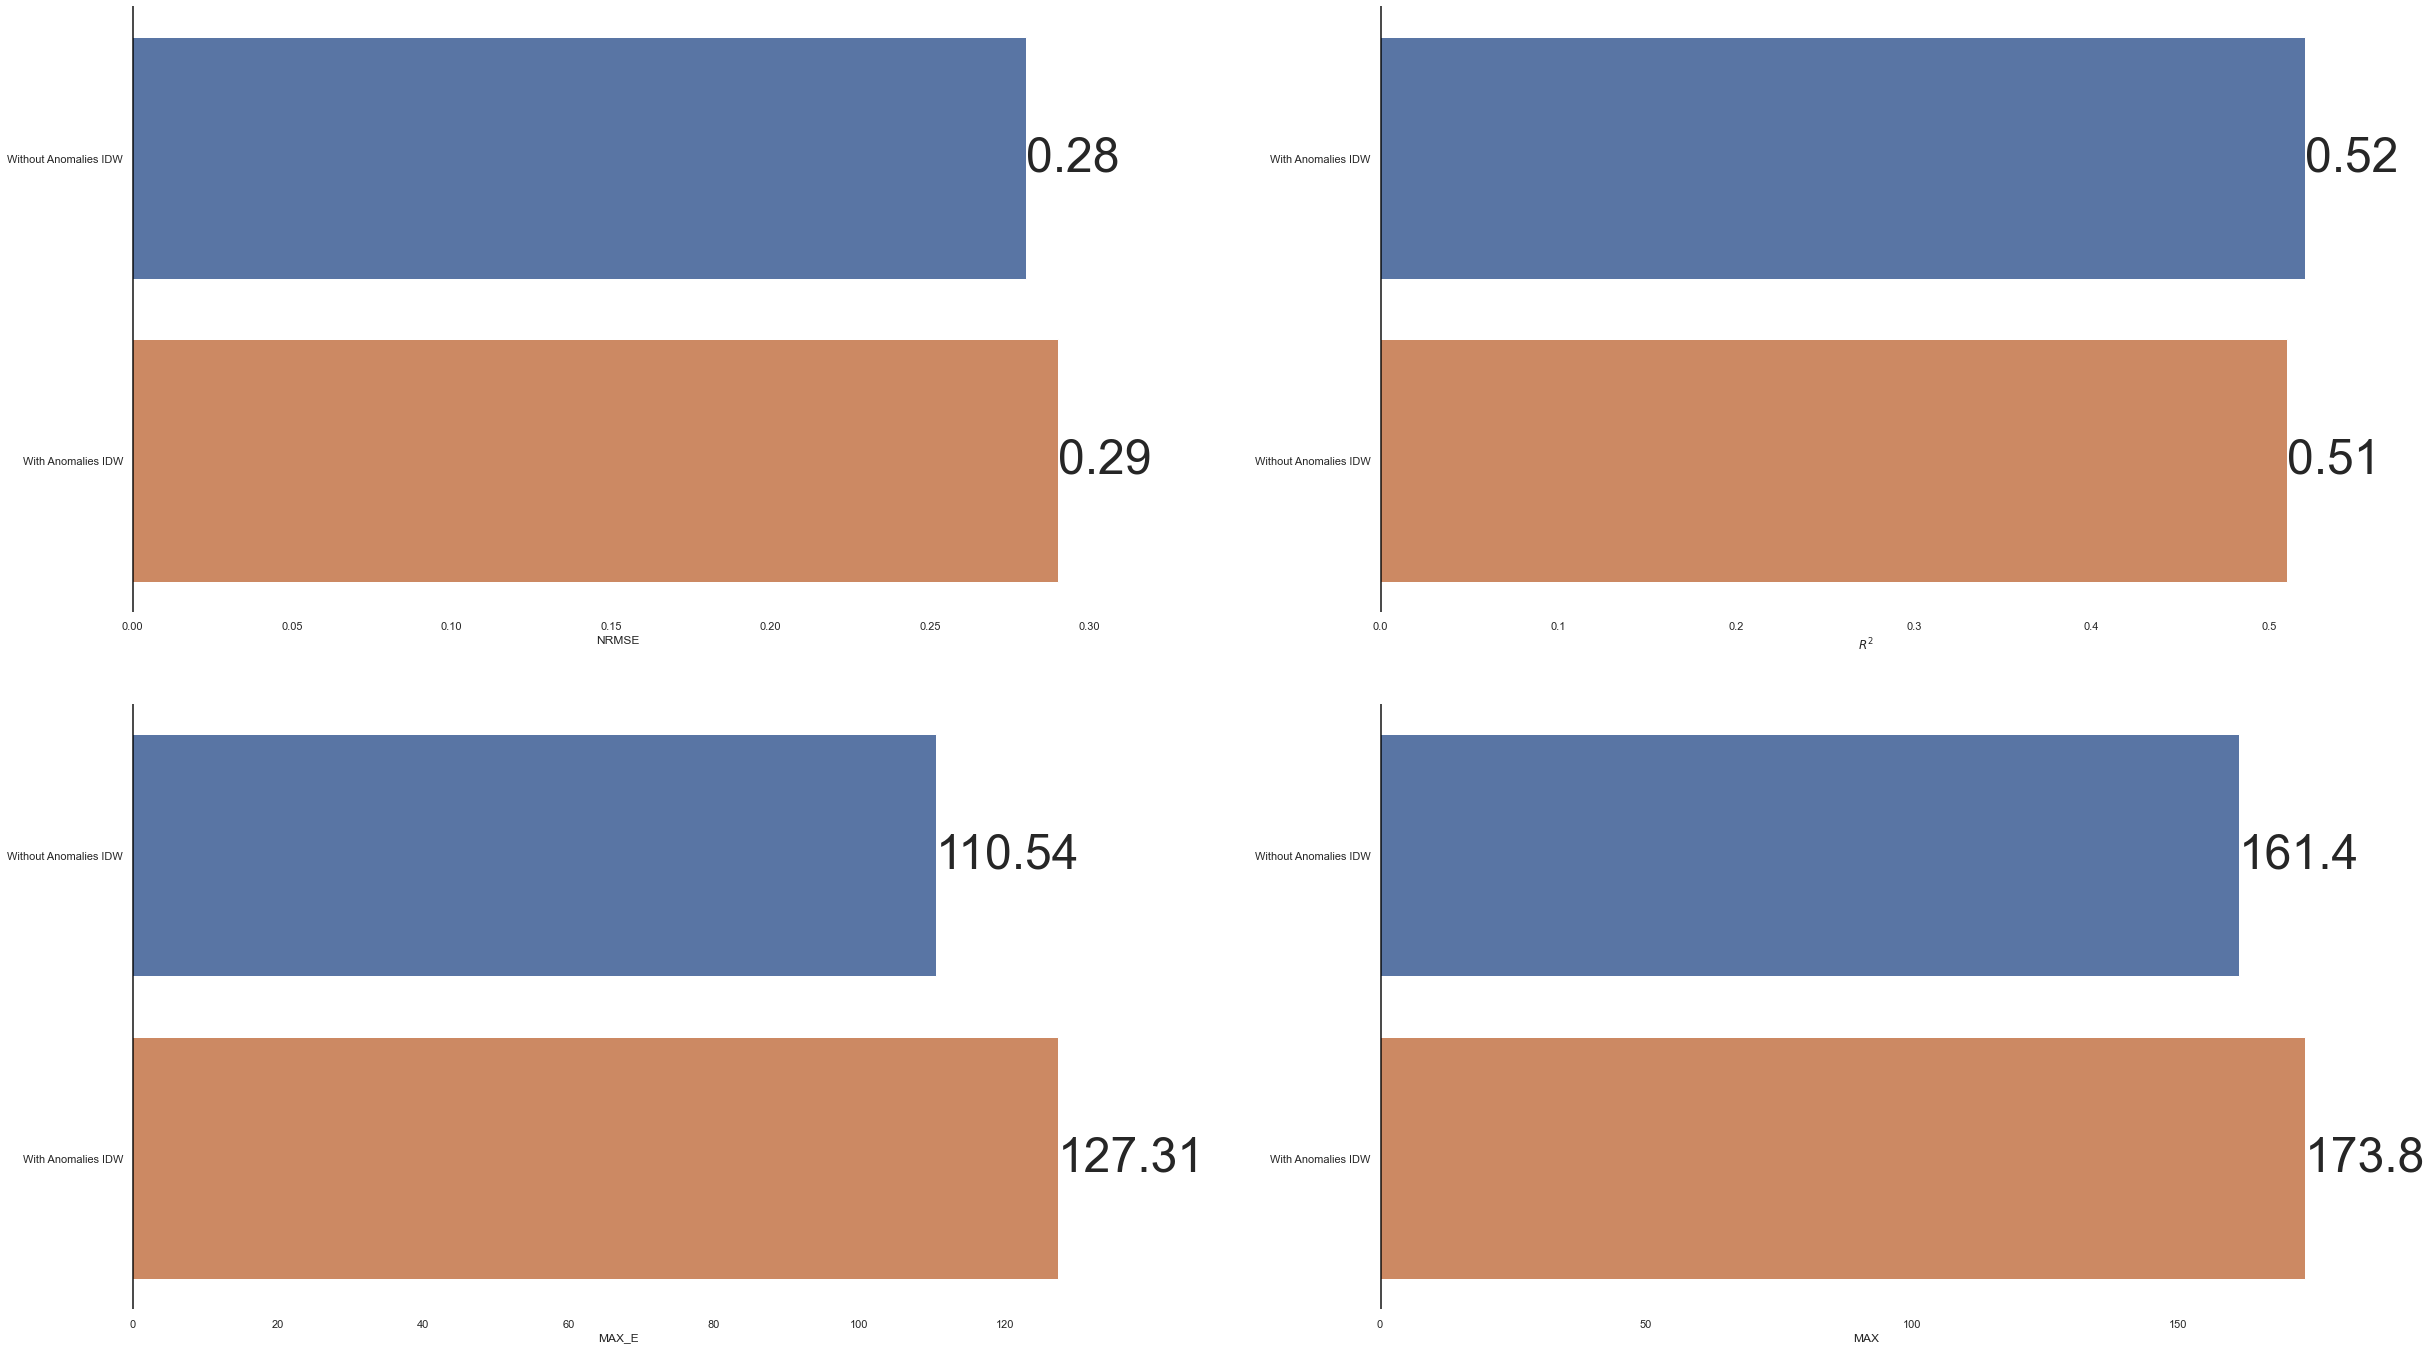

In [11]:
KPI_W = pd.DataFrame()
files = [filename for filename in os.listdir(DIR/'KPI')  if 'rab' in filename]
for file in zip(files):
    path = DIR/'KPI'/f'{file[0]}'
    tmp_df = pd.read_csv(path, index_col=0, sep='\t')
    KPI_W = pd.concat([tmp_df, KPI_W], axis=1)
    
KPI_W.columns = ['Without Anomalies IDW', 'With Anomalies IDW']

# Initialize auc_score dictionary

# Set figure size and create barplot

fig, axs = plt.subplots(2,2,figsize=(35, 20))

sns.set(font_scale = 4)

#fig.set_size_inches(30,30)

#scores = ['RMSE', 'NRMSE','MAE', 'MAPE', 'CD','EV', 'MAX_E','MIN_E' ,'MedAE', 'MPE']
scores = ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 'Stdev', 
          'RSD', 'Mean','Median','MedAE', 'MPE', 'ACC', 'CCC']

scores = ['NRMSE','$R^2$','MAX_E', 'MAX']
#subfile = 'HOD'
#files_rg = [ x for x in files_rg if subfile in x ]
for score, ax in zip(scores, axs.flatten()):



    if score in ['$R^2$','EV' ,'Max', 'MPE', 'ACC','CCC']:
        x_data = KPI_W.loc[score, :].sort_values(ascending=False).index
        y_data = KPI_W.loc[score,:].sort_values(ascending=False)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0])

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()
    else:
        x_data = KPI_W.loc[score,:].sort_values().index
        y_data = KPI_W.loc[score,:].sort_values()
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0], )

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()




# Save Figure
#  fig.savefig(DIR/'fig'/"fig_s4.jpeg", bbox_inches='tight', dpi=300 )


# Pre-evalaution

In [12]:
kfold = 10 
cv = KFold(n_splits=kfold, random_state=None, shuffle=True)

KPI_afr_lr = pd.DataFrame()
results_W = pd.DataFrame()

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) * -1


#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)




for best_features in range(8,16):  
    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)

    rfe = RFE(regressor, n_features_to_select = best_features, step = 1, verbose = 1)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("reducer", rfe),   ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)



    model_pipeline.fit(X_afr_lr, y_afr_lr)

    
    y_predict = model_pipeline.predict(X_afr_lr)
    

    KPI_afr_lr.loc['NRMSE', f'RFE_{best_features}'] = nrmse(y_afr_lr, y_predict) *-1
    KPI_afr_lr.loc['RMSE', f'RFE_{best_features}'] =mean_squared_error(y_afr_lr, y_predict, squared=False) 
    KPI_afr_lr.loc['MAE', f'RFE_{best_features}'] = mean_absolute_error(y_afr_lr, y_predict)  
    KPI_afr_lr.loc['MAPE', f'RFE_{best_features}'] = mean_absolute_percentage_error(y_afr_lr, y_predict) 
    KPI_afr_lr.loc['CD', f'RFE_{best_features}'] = r2_score(y_afr_lr, y_predict)
    KPI_afr_lr.loc['EV', f'RFE_{best_features}'] = explained_variance_score(y_afr_lr, y_predict)
    KPI_afr_lr.loc['CCC', f'RFE_{best_features}'] = concordance_correlation_coefficient(y_afr_lr, y_predict)
    KPI_afr_lr.loc['MAX', f'RFE_{best_features}'] = y_predict.max()
    KPI_afr_lr.loc['MIN', f'RFE_{best_features}'] = y_predict.min()
    
    KPI_afr_lr.loc['MAX_E',  f'RFE_{best_features}'] = round( max_error(y_afr_lr, y_predict), 3)
    KPI_afr_lr.loc['MedAE',  f'RFE_{best_features}'] = round( median_absolute_error(y_afr_lr, y_predict), 3) 
    KPI_afr_lr.loc['MPE',  f'RFE_{best_features}'] = round(np.mean((y_afr_lr -y_predict)/y_afr_lr) , 3)
    KPI_afr_lr.loc['ACC',  f'RFE_{best_features}'] = round(100 - mean_absolute_percentage_error(y_afr_lr, y_predict) *100, 3)
    KPI_afr_lr.loc['Mean',  f'RFE_{best_features}'] = round(np.mean(y_predict),3)
    KPI_afr_lr.loc['Median',  f'RFE_{best_features}'] = round(np.median(y_predict),3)
    KPI_afr_lr.loc['Stdev',  f'RFE_{best_features}'] = round(np.std(y_predict),3)
    KPI_afr_lr.loc['RSD',  f'RFE_{best_features}'] = round(np.std(y_predict) / np.mean(y_predict) ,3)
    
       
  

    
    results_W[f'RFE_{best_features}'] =y_predict.reshape(-1,)
    # Print message to user
    print('#'*60)



best_features = 16


scaler = PowerTransformer(method='yeo-johnson',standardize=True)


numeric_transformer = scaler

categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


preprocessor = ColumnTransformer(
    transformers=[
   ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
steps=[("preprocessor", preprocessor), ("reducer", rfe), ("regressor", regressor)]


# Initialize Pipeline object
pipeline= Pipeline(steps = steps)

model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)

model_pipeline.fit(X_afr_lr, y_afr_lr)


y_predict = model_pipeline.predict(X_afr_lr)


KPI_afr_lr.loc['NRMSE', f'RFE_{best_features}'] = nrmse(y_afr_lr, y_predict) *-1
KPI_afr_lr.loc['RMSE', f'RFE_{best_features}'] =mean_squared_error(y_afr_lr, y_predict, squared=False) 
KPI_afr_lr.loc['MAE', f'RFE_{best_features}'] = mean_absolute_error(y_afr_lr, y_predict)  
KPI_afr_lr.loc['MAPE', f'RFE_{best_features}'] = mean_absolute_percentage_error(y_afr_lr, y_predict) 
KPI_afr_lr.loc['CD', f'RFE_{best_features}'] = r2_score(y_afr_lr, y_predict)
KPI_afr_lr.loc['EV', f'RFE_{best_features}'] = explained_variance_score(y_afr_lr, y_predict)
KPI_afr_lr.loc['CCC', f'RFE_{best_features}'] = concordance_correlation_coefficient(y_afr_lr, y_predict)
KPI_afr_lr.loc['MAX', f'RFE_{best_features}'] = y_predict.max()
KPI_afr_lr.loc['MIN', f'RFE_{best_features}'] = y_predict.min()

KPI_afr_lr.loc['MAX_E',  f'RFE_{best_features}'] = round( max_error(y_afr_lr, y_predict), 3)
KPI_afr_lr.loc['MedAE',  f'RFE_{best_features}'] = round( median_absolute_error(y_afr_lr, y_predict), 3) 
KPI_afr_lr.loc['MPE',  f'RFE_{best_features}'] = round(np.mean((y_afr_lr -y_predict)/y_afr_lr) , 3)
KPI_afr_lr.loc['ACC',  f'RFE_{best_features}'] = round(100 - mean_absolute_percentage_error(y_afr_lr, y_predict) *100, 3)
KPI_afr_lr.loc['Mean',  f'RFE_{best_features}'] = round(np.mean(y_predict),3)
KPI_afr_lr.loc['Median',  f'RFE_{best_features}'] = round(np.median(y_predict),3)
KPI_afr_lr.loc['Stdev',  f'RFE_{best_features}'] = round(np.std(y_predict),3)
KPI_afr_lr.loc['RSD',  f'RFE_{best_features}'] = round(np.std(y_predict) / np.mean(y_predict) ,3)





results_W[f'RFE_{best_features}'] =y_predict.reshape(-1,)
# Print message to user
print('#'*60)





Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
############################################################
Fitting estimator with 16 features.
Fitting estimator with 15 

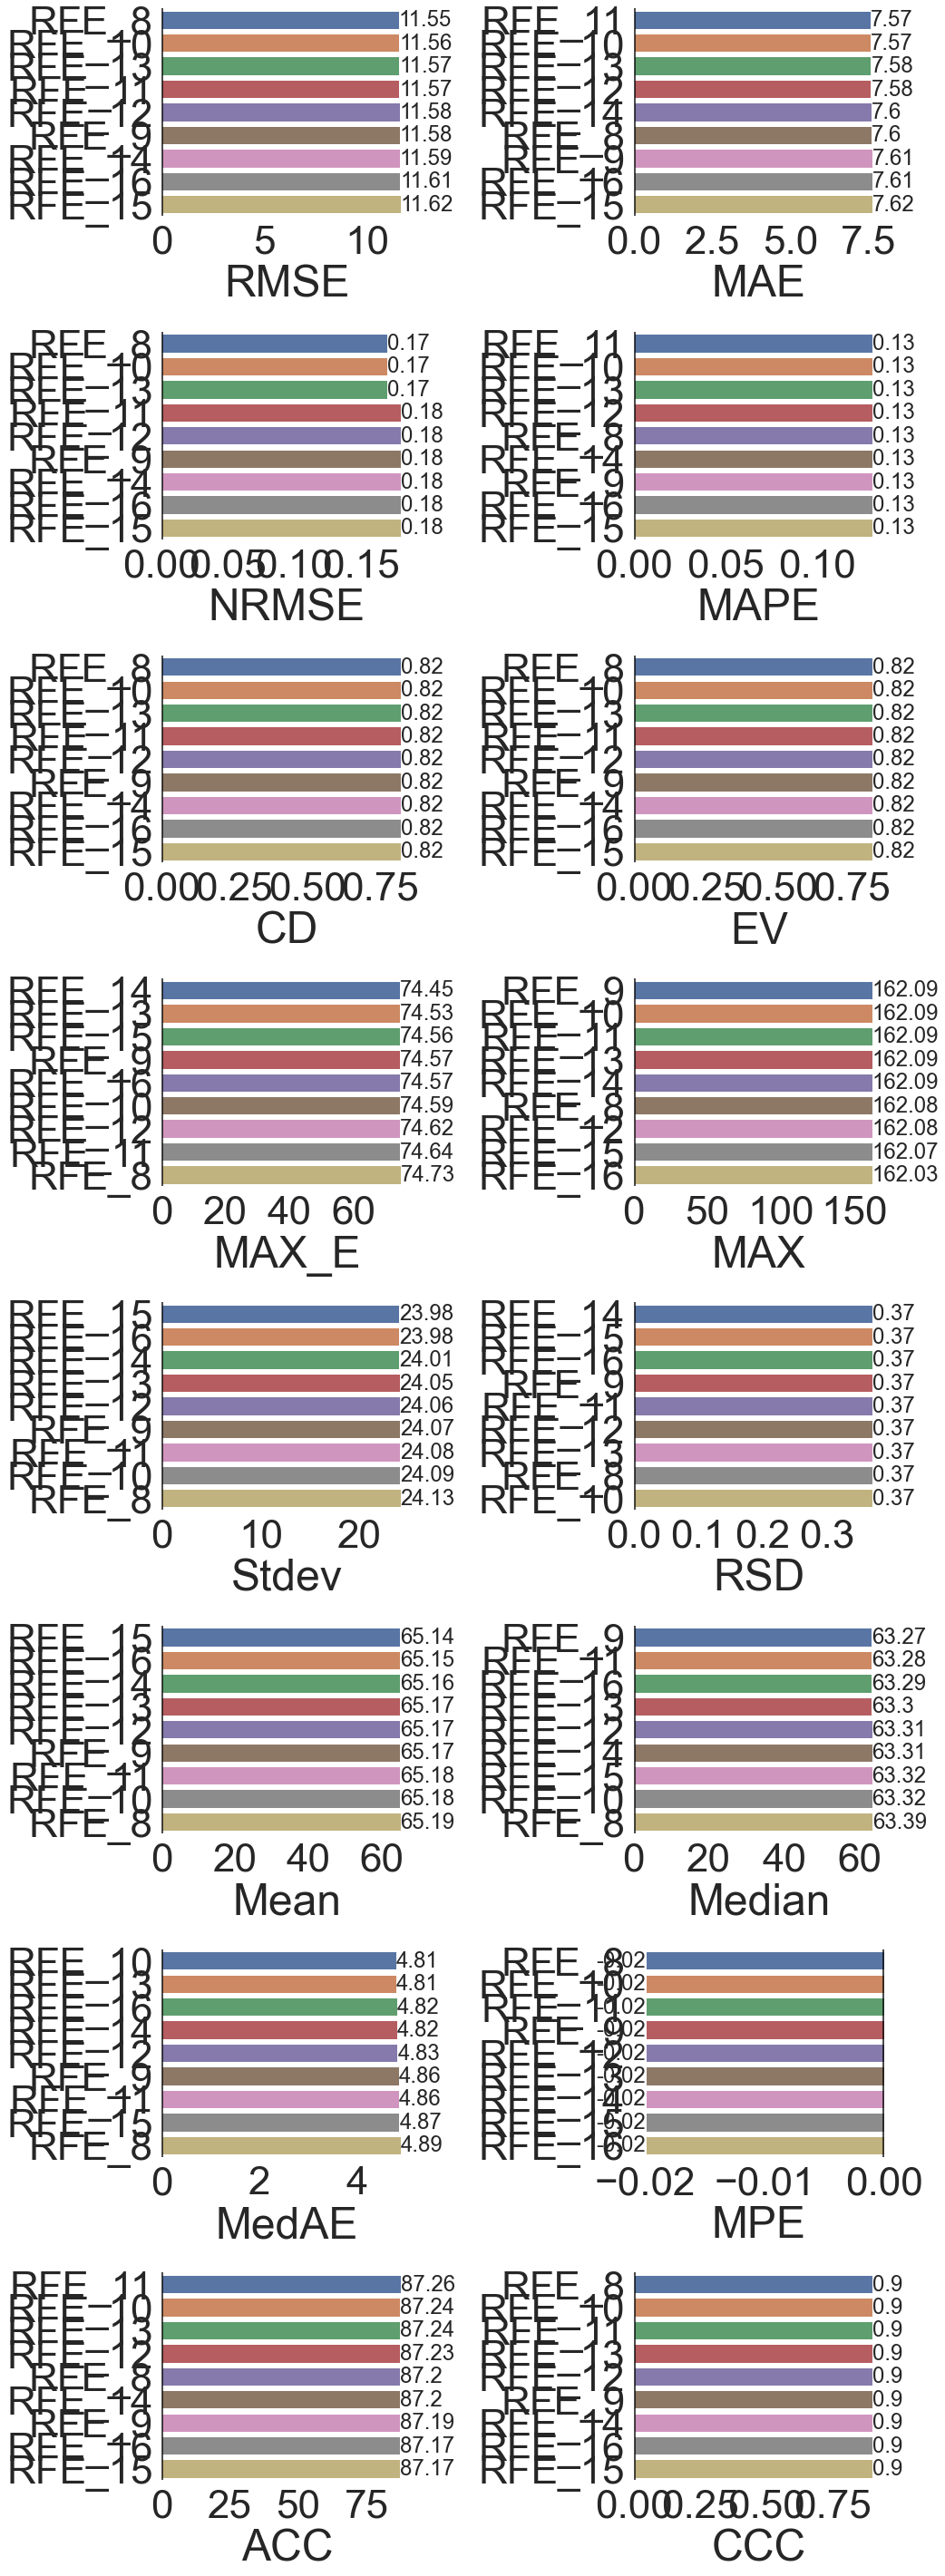

In [13]:


# Initialize auc_score dictionary

# Set figure size and create barplot

fig, axs = plt.subplots(8,2,figsize=(15, 40))

sns.set(style="whitegrid", color_codes=True, font_scale = 2)
#fig.set_size_inches(30,30)

#scores = ['RMSE', 'NRMSE','MAE', 'MAPE', 'CD','EV', 'MAX_E','MIN_E' ,'MedAE', 'MPE']

scores = ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 
          'Stdev', 'RSD', 'Mean','Median','MedAE', 'MPE', 'ACC', 'CCC']

# Set graph style
sns.set(font_scale = 2)
n_models = 30
#subfile = 'HOD'
#files_rg = [ x for x in files_rg if subfile in x ]
for score, ax in zip(scores, axs.flatten()):




    
    cols  = KPI_afr_lr.loc[score,:].sort_values(ascending=False).index.tolist()


    if score in ['CD','EV' ,'MAX', 'MPE', 'ACC','CCC']:
        
        
        x_data = KPI_afr_lr.loc[score,cols].sort_values(ascending=False).index
        y_data = KPI_afr_lr.loc[score,cols].sort_values(ascending=False).round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0])

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()
    else:
        x_data = KPI_afr_lr.loc[score,cols].sort_values().index
        y_data = KPI_afr_lr.loc[score,cols].sort_values().round(2)
        bar = sns.barplot(y_data[:], x_data[:] ,     ax=ax)
        bar.bar_label(ax.containers[0], )

        # Generate a bolded horizontal line at y = 0
        ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

        # Turn frame off
        ax.set_frame_on(False)

        #ax.legend(loc='upper left')

        # Tight layout
        plt.tight_layout()



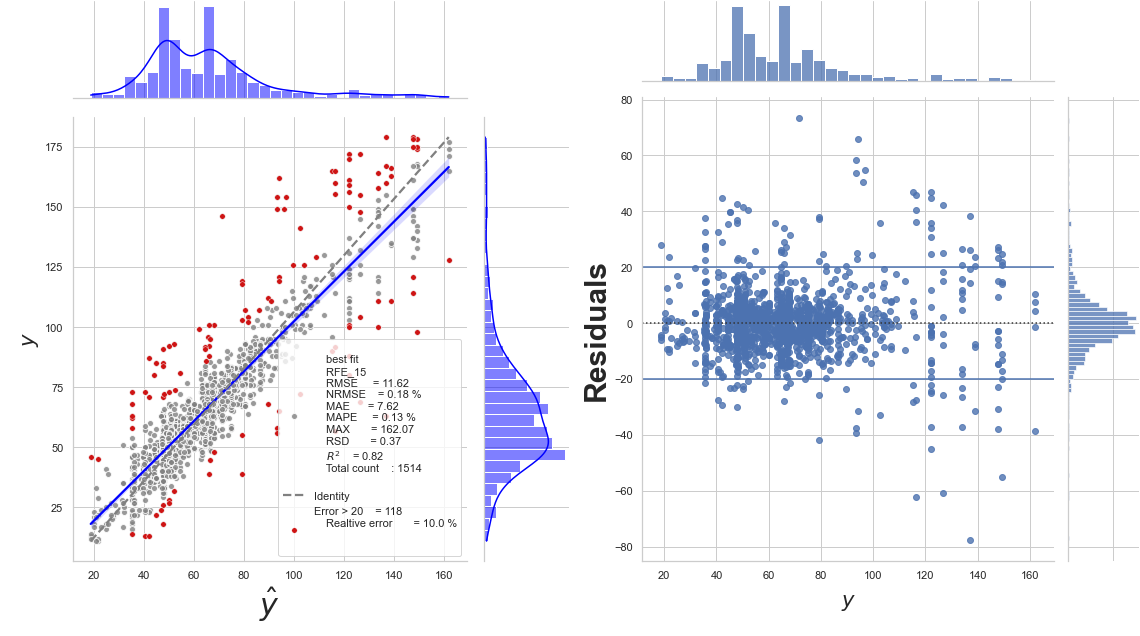

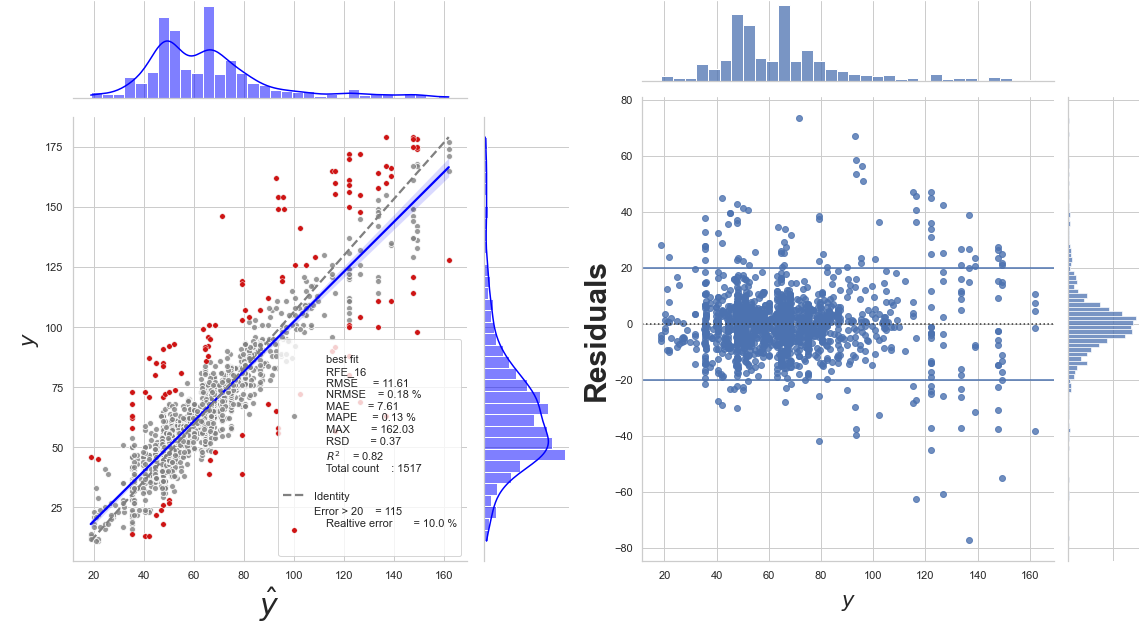

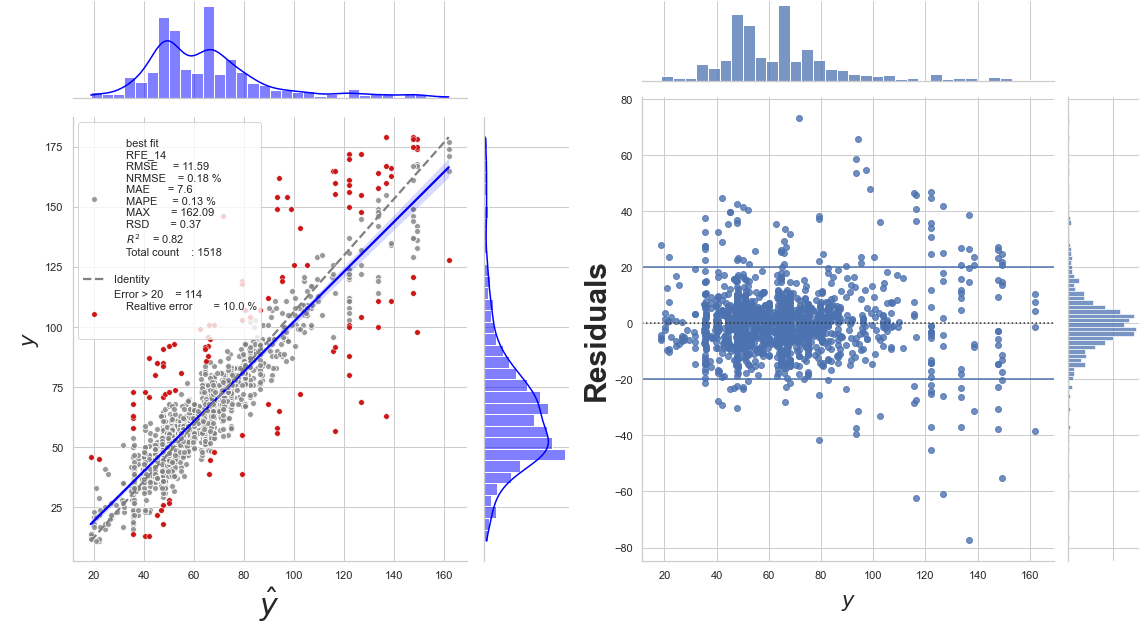

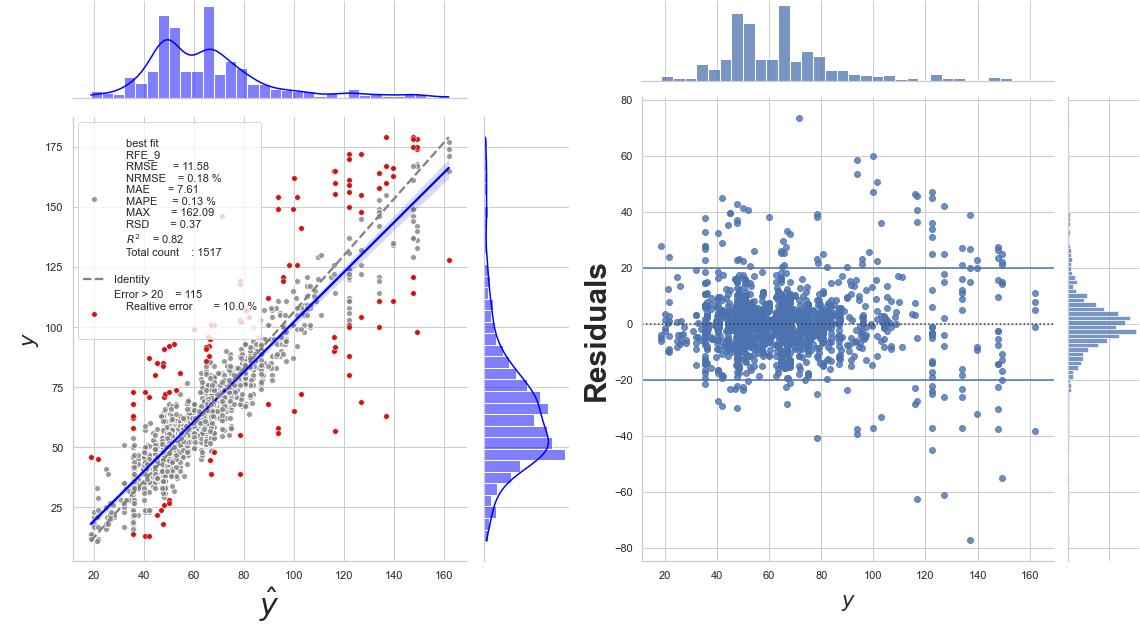

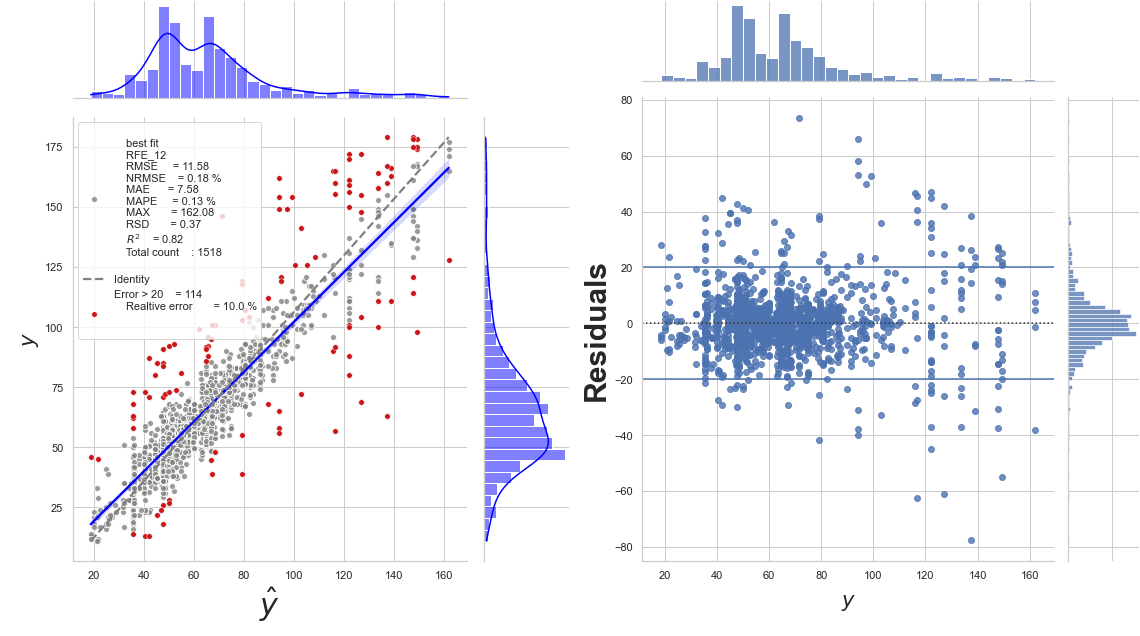

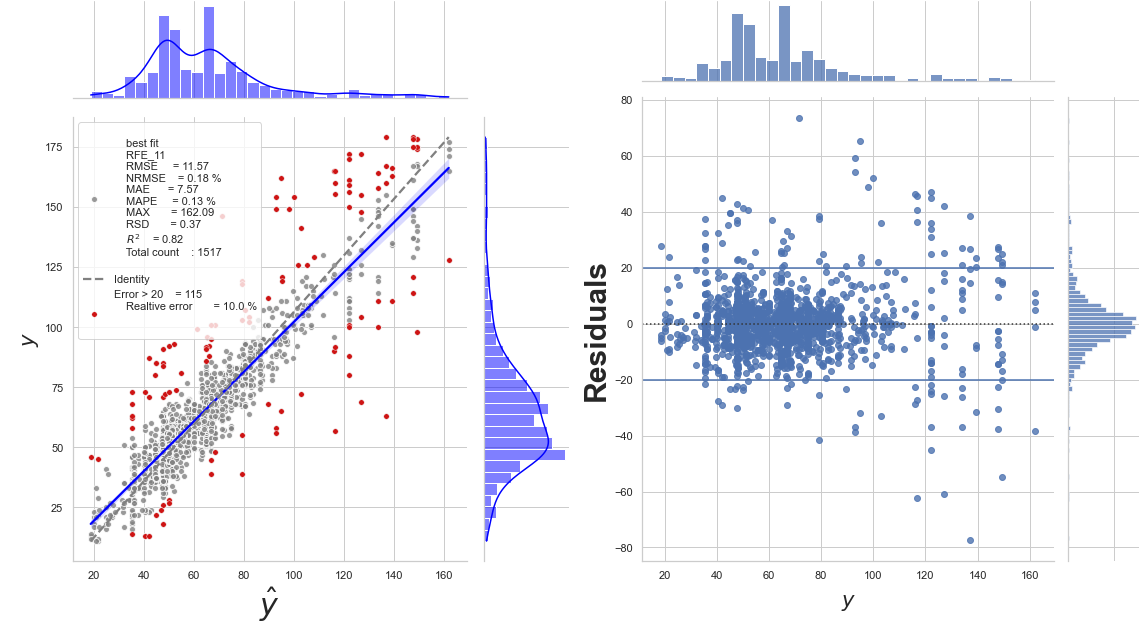

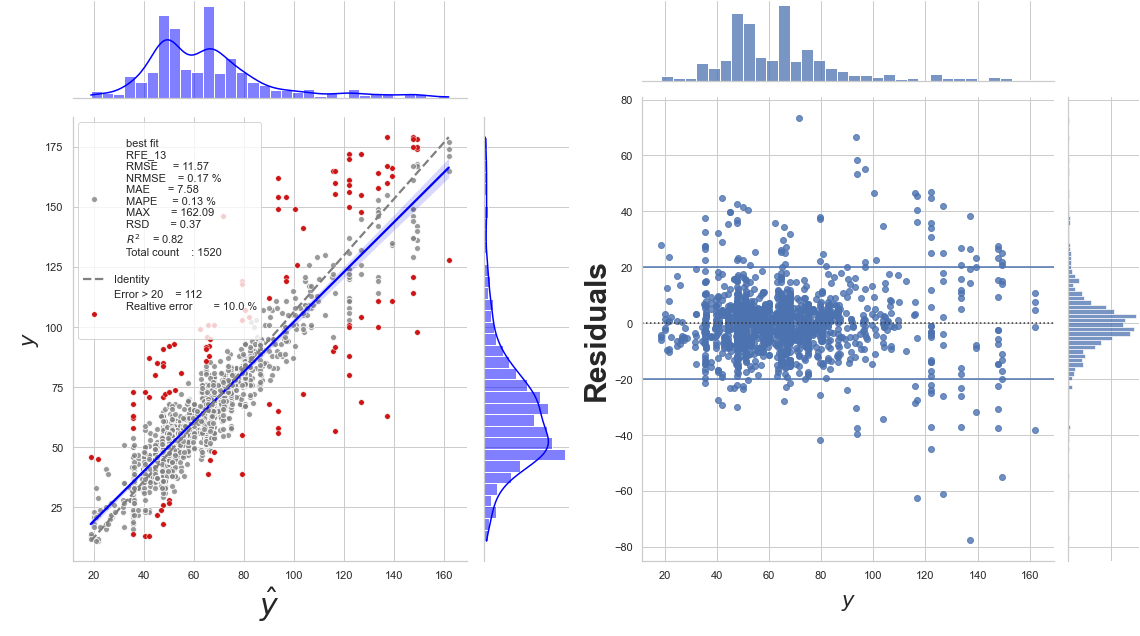

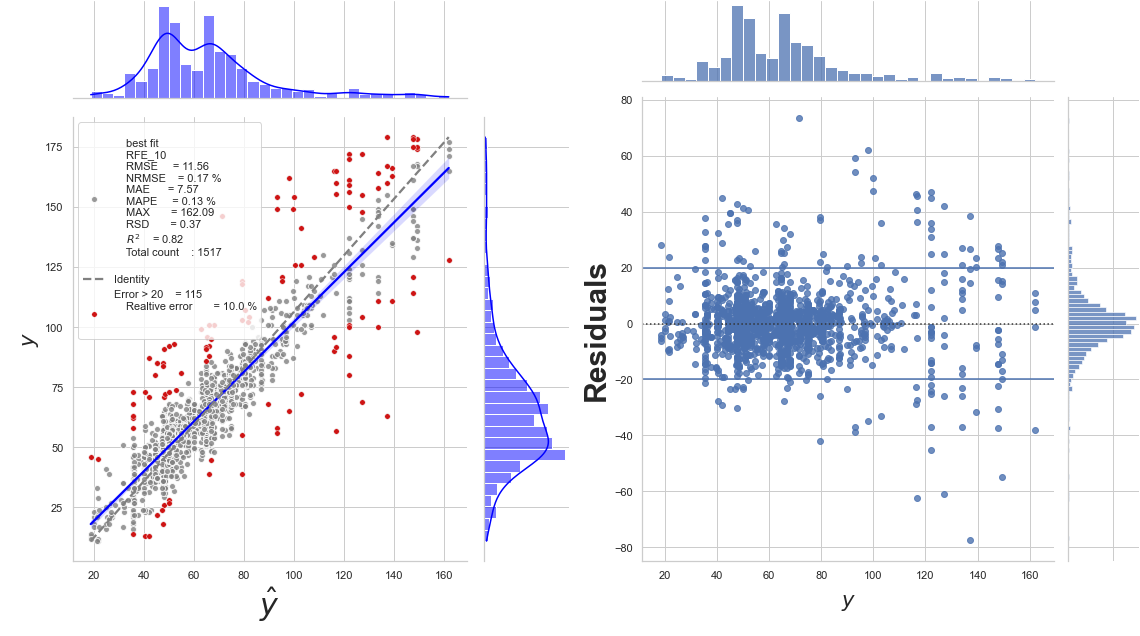

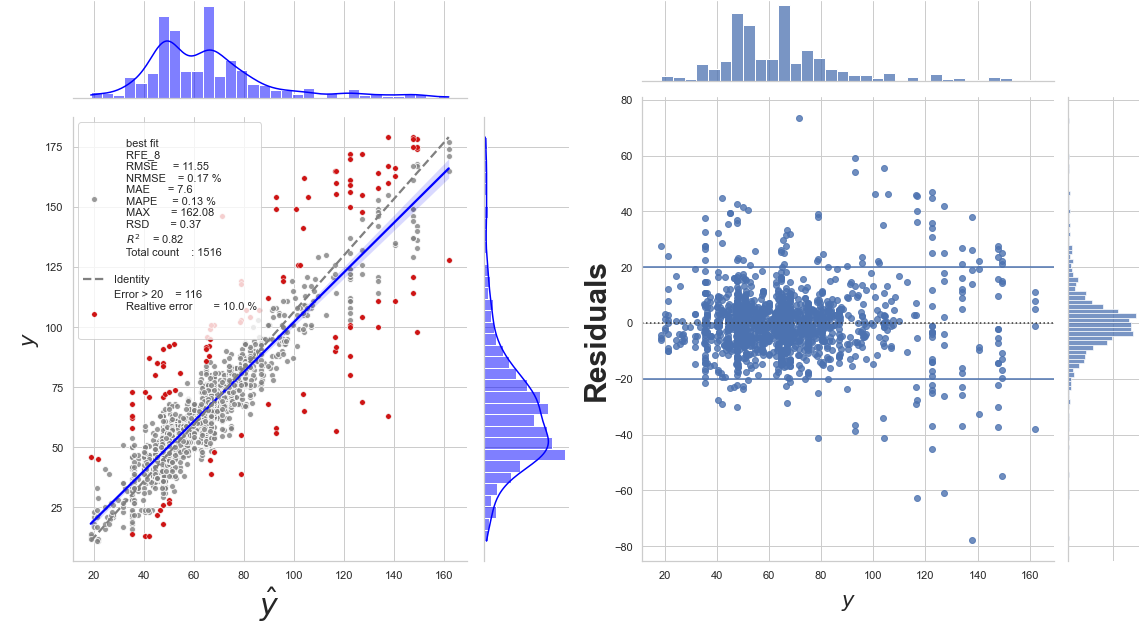

In [14]:
sns.set(style="whitegrid")

# ['RMSE', 'MAE', 'NRMSE','MAPE', 'CD','EV', 'MAX_E', 'MAX', 'Stdev', 'RSD', 'Mean','Median','MedAE', 'MPE', 'Acc']
# False ['CD','EV' ,'MAX', 'MPE']

#len(KPI_afr_lr)
n_models = 10

rfe_range = [col  for col in KPI_afr_lr.columns]

score = 'NRMSE'
columns_W = KPI_afr_lr.loc[score,rfe_range].sort_values(ascending=False).index.tolist()

results_W['y'] = y_afr_lr


threshold = 20

for column in columns_W[:n_models]:
    mask = np.abs(results_W['y'] - results_W[column]) > threshold
    y_predict = results_W[column]
    
    g0 =sns.jointplot( x=column, y='y', data=results_W, kind='reg', size=12,   ratio=4, 
                        marginal_kws={'lw':1, 'color':'blue'}, 
                  scatter_kws={"color": "grey", "edgecolor":"w"}, line_kws={"color": "blue"},
    label=   
    f'''
    best fit
    {column}
    RMSE     = {round(KPI_afr_lr.loc['RMSE', column],2)}
    NRMSE    = {round(KPI_afr_lr.loc['NRMSE', column],2)} %
    MAE      = {round(KPI_afr_lr.loc['MAE', column],2)}
    MAPE     = {round(KPI_afr_lr.loc['MAPE', column],2)} %
    MAX       = {round(KPI_afr_lr.loc['MAX', column],2)}
    RSD       = {round(KPI_afr_lr.loc['RSD', column],2)}
    $R^2$    = {round(KPI_afr_lr.loc['CD', column],2)}
    Total count    : {len(y_predict) - len(y_predict[mask])}   
        ''' )

    sns.regplot([results_W[column].min(), results_W[column].max()], [results_W['y'].min(), results_W['y'].max()], \
                ci=None, scatter=False, ax= g0.ax_joint, line_kws={"color": "grey", 'ls':'--'} , label = 'Identity')

    sns.scatterplot(results_W[column][mask],results_W['y'][mask], color="#ce1414",\
                    s=30,  ax= g0.ax_joint, edgecolor="white",
    label = 
    f'''Error > {threshold}    = {len(y_predict[mask])}
    Realtive error       = {round(len(y_predict[mask]) / len(y_predict), 1)  *100} %

    ''' )

    g0.set_axis_labels( '$\hat{y}$','$_y$', fontsize=30, fontweight='bold')
    g0.fig.suptitle('PREDICTED vs ACTUAL',fontsize=20)

    g0.ax_marg_y.grid('on') 

    #plt.legend()

    plt.tight_layout()
    
    
    #####
    
    g1 = sns.jointplot( x=column, y='y', data=results_W, kind="resid", size=12, 
                         line_kws={"color": "blue", 'lowess':True, 'robust':True},     
                         )


    #plot.ax_joint.axvline(x=6)
    g1.ax_joint.axhline(y=threshold )
    g1.ax_joint.axhline(y=-threshold)


    g1.set_axis_labels('$_y$', 'Residuals', fontsize=30, fontweight='bold')
    g1.fig.suptitle(column,fontsize=20)

    g1.ax_marg_y.grid('on') 

    plt.tight_layout()
    
    
    
    
    
    fig = plt.figure(figsize=(16,9))
    fig.set_size_inches(16,9)


    gs = gridspec.GridSpec(1, 2)

    mg0 = SeabornFig2Grid(g0, fig, gs[0])
    mg1 = SeabornFig2Grid(g1, fig, gs[1])

    gs.tight_layout(fig)


    plt.show()


In [329]:
#rfecv this process is more stable
 
kfold = 10

cv = KFold(n_splits=kfold, random_state=None, shuffle=True)

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    cost  = mean_squared_error(y_true, y_pred, squared=False)
    return cost/(y_true.mean()) 

#scoring = make_scorer(nrmse , greater_is_better=False )
nrmse_score = make_scorer(nrmse , greater_is_better=False)

#scoring = make_scorer(nrmse , greater_is_better=False )
ccc_score = make_scorer(concordance_correlation_coefficient , greater_is_better=True)

scorings = {
    '$NRMSe$':nrmse_score,
    #'RMSE':'neg_root_mean_squared_error', 
    #'MAE':'neg_mean_absolute_error', 
    #'MAPE':'neg_mean_absolute_percentage_error', 
    '$R^2$':'r2',
    #'EV':'explained_variance'   
    #'$p_c$': ccc_score,    
}

results ={}

tuned_params = {item[11:]: best_params[item][0] for item in best_params}
regressor.set_params(**tuned_params)


for key, score in scorings.items():



    # Initialize RFECV object
    feature_selector = RFECV(regressor, cv = cv, step = 1, #n_jobs=-1, 
                             scoring = score, verbose = 1)
    

    # Fit RFECV
    feature_selector .fit(X_afr_lr, np.ravel(y_afr_lr))
    #feature_selector .fit(X_w, np.ravel(y_w))
    results[key] = feature_selector

    # Get selected features
    #feature_names = X_train_corr.columns
    #selected_features = feature_names[feature_selector.support_].tolist()

    print(f'terminated {key} {score}\n')
    print('terminated')



Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fittin

Optimal number of features : 15


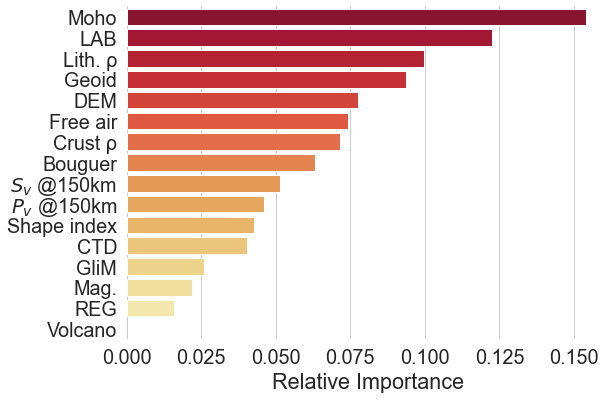

In [330]:
# this isthe ranking of RFECV it is more stable
sns.set(style="whitegrid", color_codes=True, font_scale = 1.8)
fig, ax = plt.subplots(figsize=(9, 6))


print('Optimal number of features : %d' % feature_selector.n_features_)

rank = pd.DataFrame(feature_selector.ranking_,columns=['Rank'])

rank['observable']=obs.loc[: , 'LABELS'].values
rank = rank.set_index("observable").sort_values(by='Rank',ascending=True)
#selected_labels = obs.loc[selected_features , 'LABELS'].values



obs = obs.reset_index(drop=False).set_index('OBS_REF')

selected_features = feature_selector.get_feature_names_out()

#obs.set_index('OBS_REF', inplace=True)

feature_importance = pd.DataFrame()
selected_labels = obs.loc[selected_features , 'LABELS'].values
feature_importance["Relative Importance"] = feature_selector.estimator_.feature_importances_ 
feature_importance["observable"]= obs.loc[selected_features , 'LABELS'].values

feature_importance = feature_importance.set_index("observable").sort_values(by='Relative Importance',ascending=False)

feature_importance = pd.concat([feature_importance, rank],  axis=1) 

sns.barplot(x = feature_importance["Relative Importance"], 
            y = feature_importance.index,
            palette = reversed(sns.color_palette('YlOrRd', 16))
           )


ax.set_ylabel('')

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()


ax.set_ylabel('')

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

Optimal number of features for $NRMSe$ : 13
Optimal number of features for $R^2$ : 15


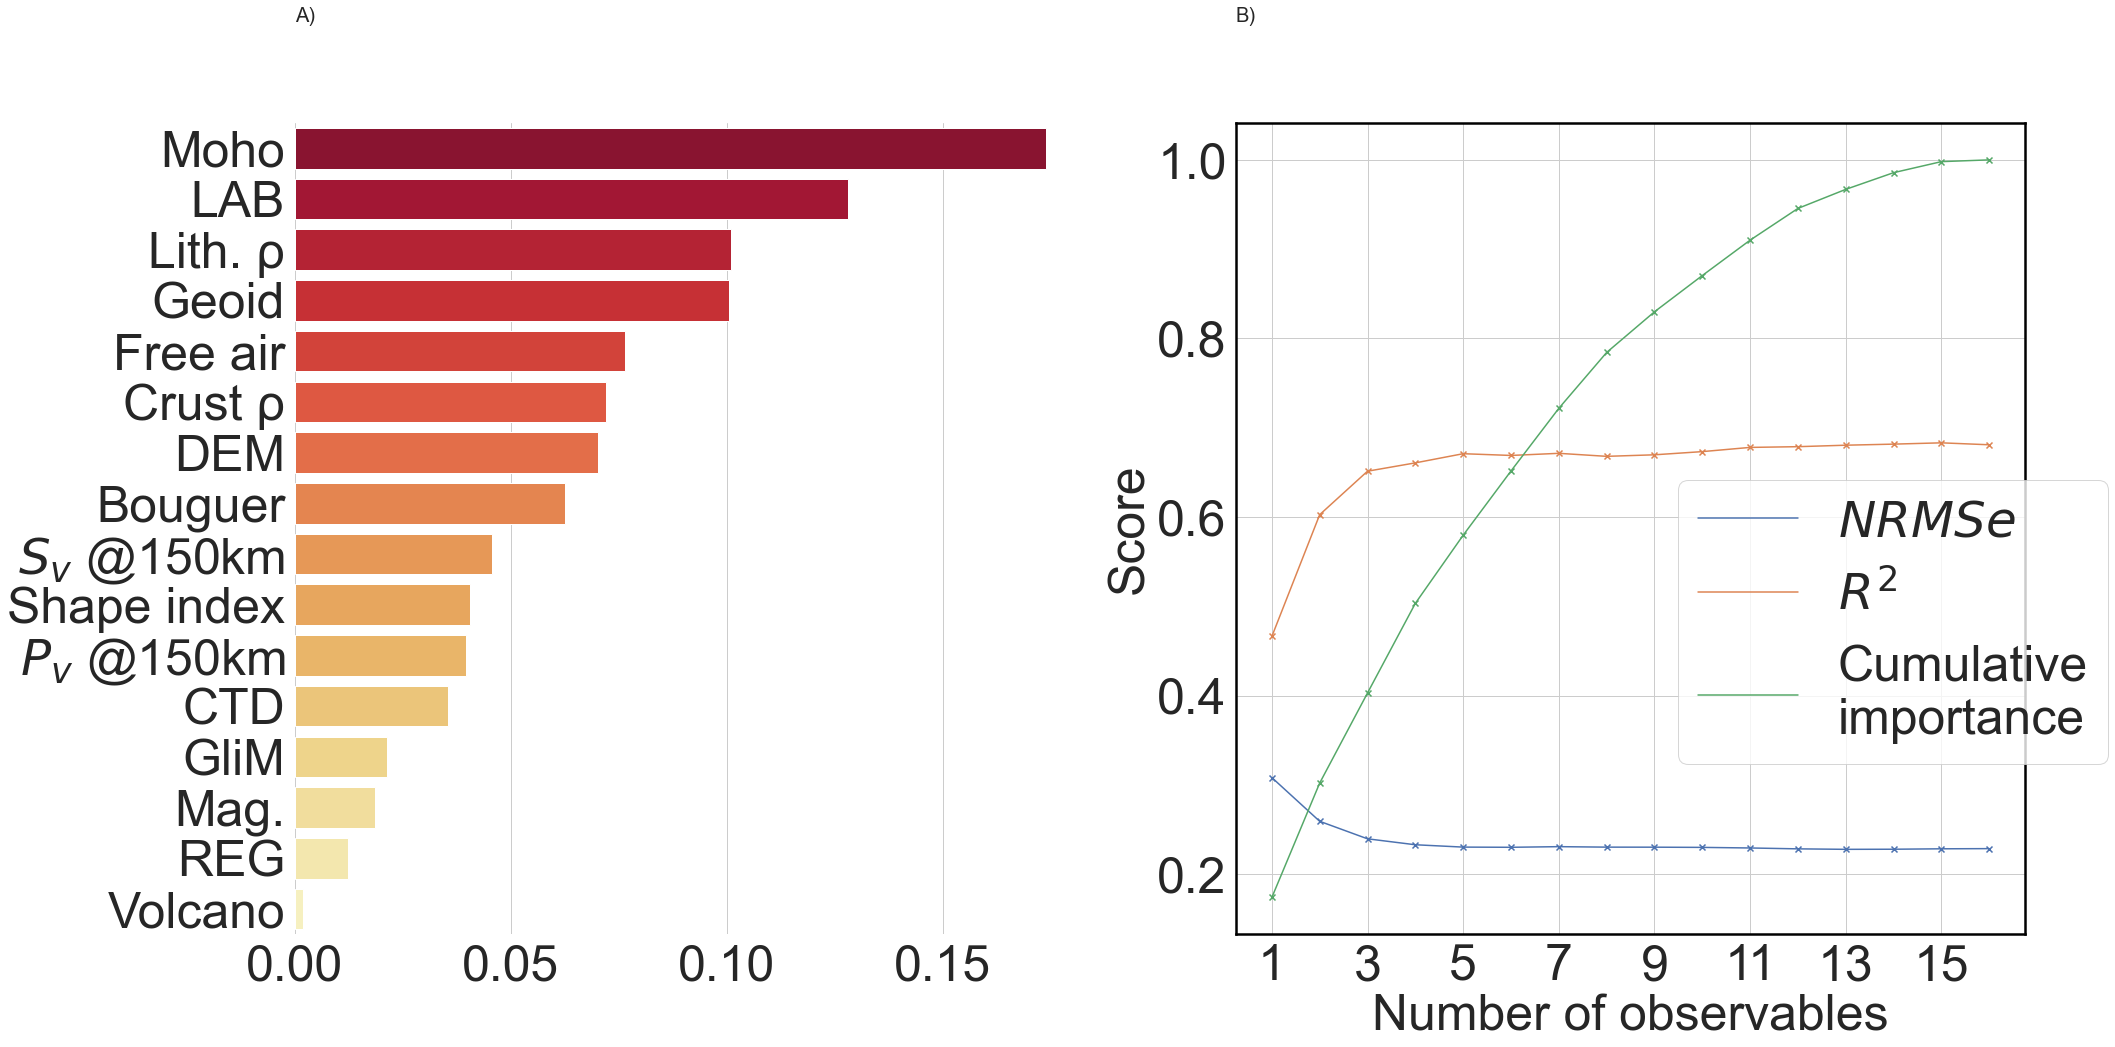

In [373]:
#feature importance 
# Get selected features data set
# should be scaled

sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

# Set figure size and create barplot
#sns.set(style="whitegrid", color_codes=True, font_scale = 1.8)
fig, ax = plt.subplots(1,2, figsize=(30, 15))

 

sns.barplot(x = feature_importance["Relative Importance"].values, 
            y = feature_importance["Relative Importance"].index, ax=ax[0],
            palette = reversed(sns.color_palette('YlOrRd', 16)),  data = feature_importance)


ax[0].set_ylabel('')


# Turn frame off
ax[0].set_frame_on(False)
ax[0].locator_params(axis='x', nbins=7)


ax[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20, size=20,  y=1.1)


for key, score in scorings.items():
    #selected_features = feature_names[results[key].support_].tolist()
    # Get Performance Data
    print(f"Optimal number of features for {key} : {results[key].n_features_}")
    results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
    if results[key].grid_scores_.mean(axis=1).min() < 0:
        ax[1].plot(range(1, len(results[key].grid_scores_) + 1),                  results[key].grid_scores_.mean(axis=1)*-1, label=key)
        ax[1].scatter(range(1, len(results[key].grid_scores_) + 1), 
                    results[key].grid_scores_.mean(axis=1)*-1, marker='x')

    else:
        ax[1].plot(range(1, len(results[key].grid_scores_) + 1), 
                 results[key].grid_scores_.mean(axis=1), label=key)
        ax[1].scatter(range(1, len(results[key].grid_scores_) + 1), 
                    results[key].grid_scores_.mean(axis=1), marker='x')
        
ax[1].plot(range(1, len(results[key].grid_scores_) + 1), 
         feature_importance['Relative Importance'].cumsum().values, label=f'''Cumulative
importance''')
ax[1].scatter(range(1, len(results[key].grid_scores_) + 1), 
            feature_importance['Relative Importance'].cumsum().values, marker='x')

ax[1].set_xlabel("Number of observables")
ax[1].set_xticks([ 1,3,5,7,9,11,13,15])
ax[1].set_ylabel("Score")
ax[1].legend(loc=[.56, .21])
#plt.axvline(results[key].n_features_ ,color='r')
ax[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20, size=20,  y=1.1)



# Tight layout
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/ 'fig'/"fig_5.jpeg", bbox_inches='tight', dpi=300 )

In [334]:
# individual RFECV to calculate conribution of each feature to R2 and NRMSe



KPI_Feature = pd.DataFrame()
KPI_Feature_CV = pd.DataFrame()
results_feature_CV = pd.DataFrame()




for feature in obs.index:  
    print(feature)
    
    if feature in ['REG','GLIM']:
        X_train_afr_lr_feature = X_afr_lr[feature].cat.codes
    else:
        X_train_afr_lr_feature = X_afr_lr[feature]
    
    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)

    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[("preprocessor", preprocessor), ("regressor", regressor)]

    
    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)

    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)

    regressor.fit(X_train_afr_lr_feature.values.reshape(-1, 1), y_afr_lr.reshape(-1, 1))


    y_predict = regressor.predict(X_train_afr_lr_feature.values.reshape(-1, 1))


    KPI_Feature.loc['$NRMSe$', obs.loc[feature, 'LABELS']] = nrmse(y_afr_lr, y_predict) *-1
    #KPI_Feature.loc['MAPE', f'{feature}'] = mean_absolute_percentage_error(y, y_predict) 
    KPI_Feature.loc['$R^2$', obs.loc[feature, 'LABELS']] = r2_score(y_afr_lr, y_predict)
    #KPI_Feature.loc['EV', f'{feature}'] = explained_variance_score(y, y_predict)
    #KPI_Feature.loc['CCC', f'{feature}'] = concordance_correlation_coefficient(y, y_predict)


    for key,  scoring in scorings.items():
        score = cross_val_score(regressor, 
                                X_train_afr_lr_feature.values.reshape(-1, 1), 
                                y_afr_lr.reshape(-1, 1),
                                scoring=scoring,
                                  cv=cv)


        if score_title in ['MAPE']:
            KPI_Feature_CV.loc[key, obs.loc[feature, 'LABELS']] = score.mean() * -1
        else:
            KPI_Feature_CV.loc[key, obs.loc[feature, 'LABELS']] = score.mean()

            
feature_importance['$NRMSe$']   = KPI_Feature_CV.T['$NRMSe$'] *-1
feature_importance['$R^2$']   = KPI_Feature_CV.T['$R^2$']



print('terminated')

CTD
SI
LAB
MOHO
SV
PV
GEOID
DEM
FA
BG
EMAG2_CLASS
RHO_L
RHO_C
VOLC_DIST_W
REG
GLIM
terminated


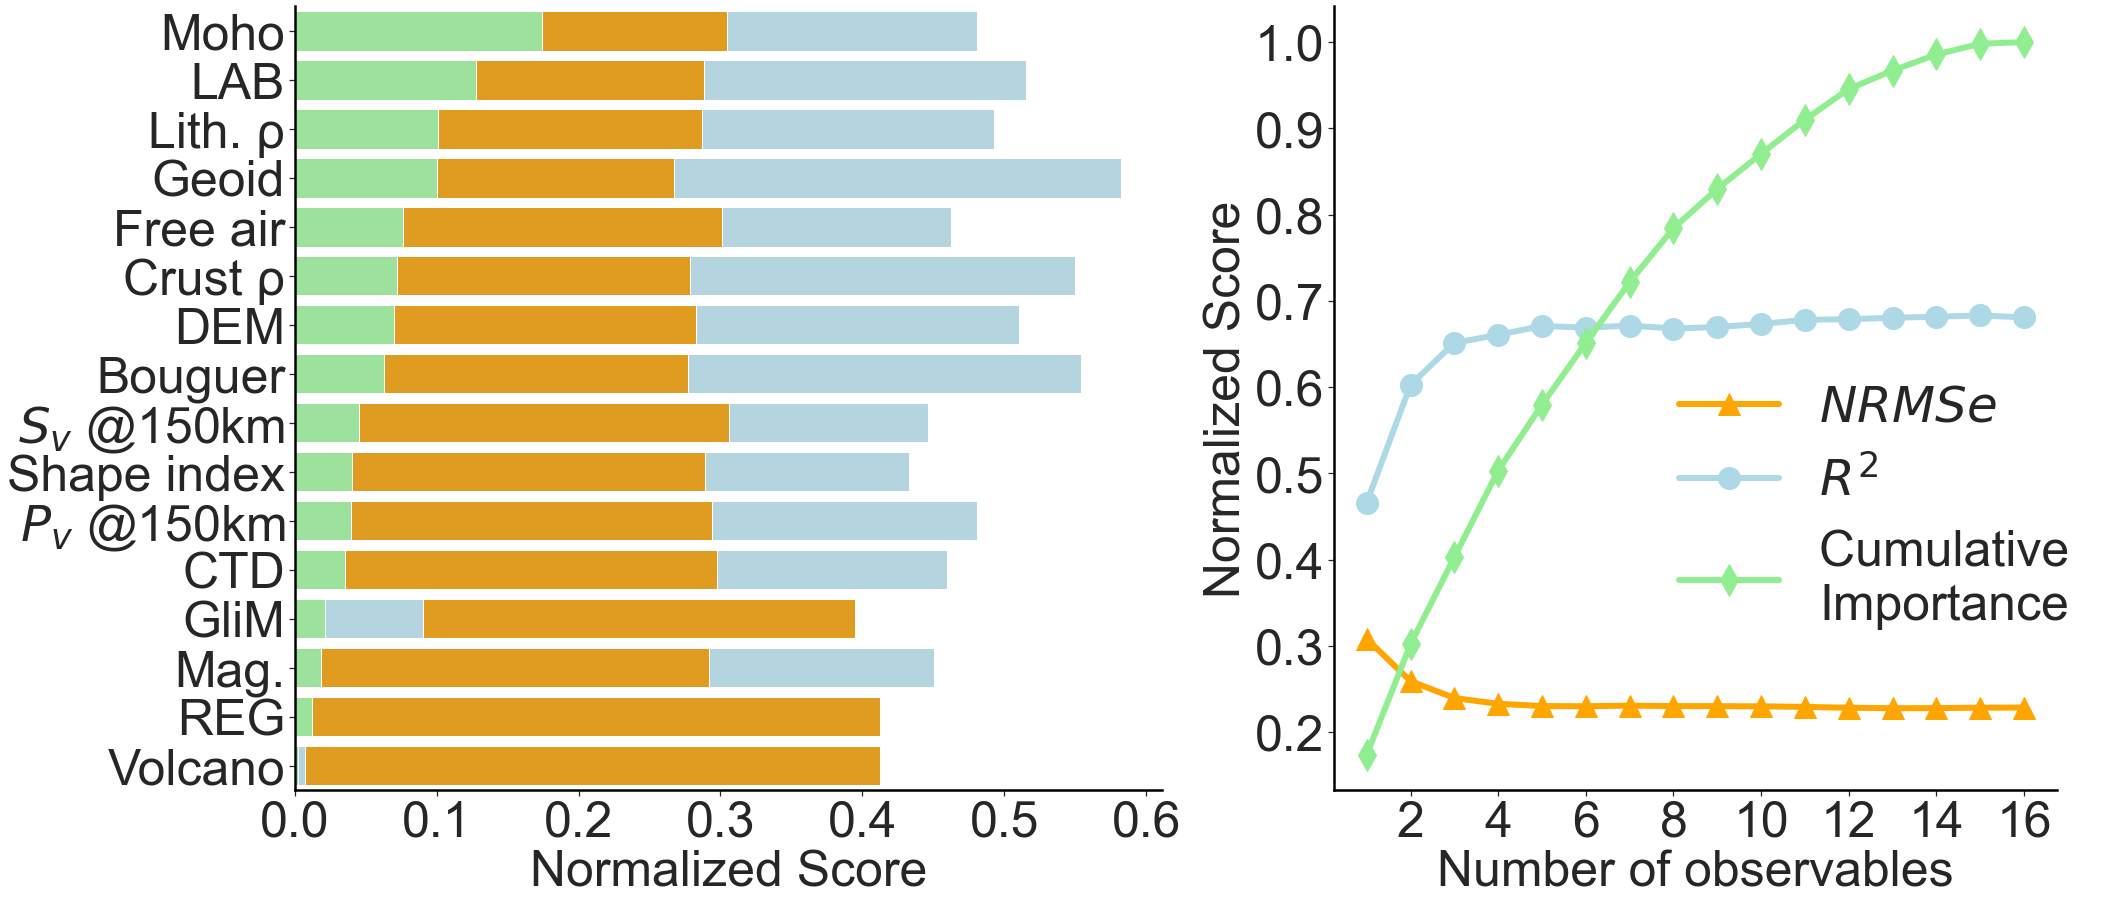

In [375]:
mask_RV_NRMSE = (feature_importance['Relative Importance'] < feature_importance['$NRMSe$']) & (feature_importance['$NRMSe$'] < feature_importance['$R^2$'])

mask_NRMSE_RV = (feature_importance['$NRMSe$'] < feature_importance['Relative Importance']) & (feature_importance['Relative Importance'] < feature_importance['$R^2$']) 
    
mask_R2_RV = (feature_importance['$R^2$'] < feature_importance['Relative Importance']) & (feature_importance['Relative Importance'] < feature_importance['$NRMSe$'])


mask_RV_R2 = (feature_importance['Relative Importance'] < feature_importance['$R^2$']) & (feature_importance['$R^2$'] < feature_importance['$NRMSe$'])

mask_NRMSE_R2 = (feature_importance['$NRMSe$'] < feature_importance['$R^2$']) & (feature_importance['$R^2$'] < feature_importance['Relative Importance']) 


mask_R2_NRMSE = (feature_importance['$R^2$'] < feature_importance['$NRMSe$']) & (feature_importance['$NRMSe$'] < feature_importance['Relative Importance'])



#feature importance 
# Get selected features data set
# should be scaled
fig, axes = plt.subplots(1,2, figsize=(30, 13),gridspec_kw={'width_ratios': [3, 2.5]})

axes.ravel()
#sns.set(style="whitegrid", color_codes=True, font_scale = 3)

params = {
    'legend.fontsize': 50,
    "axes.edgecolor" : "black", 
    "axes.linewidth" : 2.50, 
    #plt.rcParams.update({'font.size': 20})

    'xtick.labelsize': 50,
    'ytick.labelsize': 50,
    "axes.labelsize" : 50,
}
plt.rcParams.update(params)


###1
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance['$R^2$'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    sns.barplot(x = feature_importance["Relative Importance"].values * mask_RV_NRMSE.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###2
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['$R^2$'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["Relative Importance"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    

###3
if mask_R2_RV.any():
    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )


    sns.barplot(x = feature_importance["Relative Importance"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )


    
    sns.barplot(x = feature_importance['$R^2$'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    

###4
if mask_RV_R2.any():
    
    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    
    sns.barplot(x = feature_importance['$R^2$'].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )

    sns.barplot(x = feature_importance["Relative Importance"].values * mask_RV_R2.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

###5
    
if mask_NRMSE_RV.any():
    sns.barplot(x = feature_importance['$R^2$'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance["Relative Importance"].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )

    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_NRMSE_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    
####6
if mask_R2_RV.any():
    
   
    sns.barplot(x = feature_importance['$NRMSe$'].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    sns.barplot(x = feature_importance["Relative Importance"].values * mask_R2_RV.astype(int).values, 
                y = feature_importance.index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
    sns.barplot(x = feature_importance['$R^2$'].values * mask_R2_RV.astype(int).values, 
            y = feature_importance.index, 
            ax=axes[0], color='lightblue',
            )
    
    
### optimal

'''
if mask_RV_NRMSE.any():
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11], '$R^2$'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11], '$R^2$'].index, 
                ax=axes[0], color='lightblue',
                )


    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],'NRMSe'].index, 
                ax=axes[0], color='orange', label='$NRMSe$',
                )
    sns.barplot(x = feature_importance.loc[mask_RV_NRMSE[0:11],"Relative Importance"].values, 
                y = feature_importance.loc[mask_RV_NRMSE[0:11],"Relative Importance"].index,  
                ax=axes[0],  color='lightgreen',label=f"""Relative
    importance"""
                        )
    
''' 


axes[0].set_ylabel('')
axes[0].grid(False)



#axes[0].patch.set_edgecolor('black')  
#axes[0].patch.set_linewidth('3') 
# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')





axes[0].locator_params(axis='x', nbins=7)
#axes[0].legend(loc=[.55, .6], framealpha=0.5)

#axes[0].set_title(f'{sub_figs[0]})', loc ='left', pad=20, size=40,  y=1.1)
axes[0].set_xlabel("Normalized Score")


for key, score in scorings.items():
    #selected_features = feature_names[results[key].support_].tolist()
    # Get Performance Data
    #print(f"Optimal number of features for {key} : {results[key].n_features_}")
    if key == '$NRMSe$':
        results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X_afr_lr.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
        if results[key].grid_scores_.mean(axis=1).min() < 0:
            axes[1].plot(range(1, len(results[key].grid_scores_) + 1),                
                       results[key].grid_scores_.mean(axis=1)*-1, color='orange', 
                       linewidth=6,  marker="^", label=key, markersize=22,)


        else:
            axes[1].plot(range(1, len(results[key].grid_scores_) + 1), 
                     results[key].grid_scores_.mean(axis=1), color='orange', linewidth=6,
                       marker="^", label=key, markersize=22,)

    else:
      
        
        results[key].support_rfecv_df = pd.DataFrame(results[key].ranking_,index=X_afr_lr.columns,columns=['Rank']).sort_values(by='Rank',ascending=True)
        if results[key].grid_scores_.mean(axis=1).min() < 0:
            axes[1].plot(range(1, len(results[key].grid_scores_) + 1),                  
                       results[key].grid_scores_.mean(axis=1)*-1, color='lightblue',
                       linewidth=6  ,marker="o",  label=key, markersize=22,)

        else:
            axes[1].plot(range(1, len(results[key].grid_scores_) + 1), 
                     results[key].grid_scores_.mean(axis=1), color='lightblue', 
                         linewidth=6, marker="o",  label=key, markersize=22,
                       )


axes[1].plot(range(1, len(results[key].grid_scores_) + 1), 
         feature_importance['Relative Importance'].cumsum().values, linewidth=6, 
            color='lightgreen',  marker="d",  label=f'''Cumulative \nImportance''', markersize=22,)


axes[1].set_xlabel("Number of observables")

axes[1].set_ylabel("Normalized Score")
axes[1].legend(loc=[.45, .18], frameon=False)
#axes[1].legend(loc=[.01, .7])
#plt.axesvline(results[key].n_features_ ,color='r')
#axes[1].set_title(f'{sub_figs[1]})', loc ='left', pad=20, size=40,  y=1.1)
axes[1].locator_params(axis='y', nbins=10)
axes[1].locator_params(axis='x', nbins=9)
axes[1].grid(False)

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[1].yaxis.set_ticks_position('left')
axes[1].xaxis.set_ticks_position('bottom')





# Tight layout
plt.tight_layout()


# Save Figure
#fig.savefig(dir_p/'fig'/'presentation'/"fig_p6d.jpeg", bbox_inches='tight', dpi=300 )
#fig.savefig(DIR/'fig'/"fig_8.pdf", bbox_inches='tight', dpi=300 )
fig.savefig(DIR/'fig'/"fig_8.jpg", bbox_inches='tight', dpi=300 )

# Modeling

In [178]:
# this step gurantee consistency in feetaure ranking
sorted_features = obs.reset_index(drop=False).set_index('LABELS')



selected_features = []
for best_feature in range(16,3, -1):
    selected_features.extend([sorted_features.loc[feature_importance.index, 'OBS_REF'].values[0 :best_feature]])



In [96]:
pipeline_dict = {}
grids_dict = {}
selected_features_dict = {}


best_features = ['16', '15','14', '13','12', '11','10',
                 '09','08', '07','06','05','04'
                 ]


scoring = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

kfold =10
cv = KFold(n_splits=kfold, random_state=None, shuffle=True)


label = 'AFR' 

for best_feature, selected_feature in zip(best_features ,selected_features) :

    y_Afr = Afr_OD_rab_lr[target]
    X_Afr = Afr_OD_rab_lr[selected_feature]
    



    
    regressor = RandomForestRegressor()

    tuned_params = {item[11:]: best_params[item][0] for item in best_params}
    regressor.set_params(**tuned_params)
    
    scaler = PowerTransformer(method='yeo-johnson',standardize=True)


    numeric_transformer = scaler

    categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value' , unknown_value =-1)


    preprocessor = ColumnTransformer(
        transformers=[
       ("num", numeric_transformer, selector(dtype_exclude="category")),
            ("cat", categorical_transformer, selector(dtype_include="category")),
        ]
    )

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    steps=[ ("preprocessor", preprocessor),  ("regressor", regressor)]


    # Initialize Pipeline object
    pipeline= Pipeline(steps = steps)


    model_pipeline = TransformedTargetRegressor(regressor=pipeline, transformer=scaler)
    
    trained_model = model_pipeline.fit(X_Afr, y_Afr )
    
   

    ######### save

   
    pipeline_dict[f'RFE_{best_feature}'] = trained_model
    
    #grids_dict[f'RFE_{best_feature}'] =  ds_afr[selected_feature].to_array().values
    
    selected_features_dict[f'RFE_{best_feature}']   = selected_feature

    print(f'RFE_{best_feature} fitting is terminated' )




RFE_16 fitting is terminated
RFE_15 fitting is terminated
RFE_14 fitting is terminated
RFE_13 fitting is terminated
RFE_12 fitting is terminated
RFE_11 fitting is terminated
RFE_10 fitting is terminated
RFE_09 fitting is terminated
RFE_08 fitting is terminated
RFE_07 fitting is terminated
RFE_06 fitting is terminated
RFE_05 fitting is terminated
RFE_04 fitting is terminated


In [23]:
grids_dict = {}

n_features = ['16','15', '14', '13', '12', '11', '10', '09', '08', '07', '06', '05', '04']
for selected_feature, n_feature in tqdm_notebook(zip(selected_features, n_features), total = len(n_features),
                                      desc= 'processing: ' ):
    df = pd.DataFrame({'X': ds_afr_lr.XV.values.ravel(), 'Y': ds_afr_lr.YV.values.ravel()})

    for feature in tqdm_notebook(selected_feature , 
                                            desc=f'{selected_feature}: ', leave=False ):
        sleep(0.01)
        df[feature] = ds_afr_lr[feature].values.ravel()
    grids_dict[f'RFE_{n_feature}'] = df

processing:   0%|          | 0/13 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV' 'CTD'
 'GLIM' 'EMAG2_CLASS' 'REG' 'VOLC_D…

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV' 'CTD'
 'GLIM' 'EMAG2_CLASS' 'REG']:   0%|…

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV' 'CTD'
 'GLIM' 'EMAG2_CLASS']:   0%|      …

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV' 'CTD'
 'GLIM']:   0%|          | 0/13 [00…

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV' 'CTD']:   0%|          | 0/12 [00:00<?, ?…

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI' 'PV']:   0%|          | 0/11 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV' 'SI']:   0%|          | 0/10 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG' 'SV']:   0%|          | 0/9 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM' 'BG']:   0%|          | 0/8 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C' 'DEM']:   0%|          | 0/7 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA' 'RHO_C']:   0%|          | 0/6 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID' 'FA']:   0%|          | 0/5 [00:00<?, ?it/s]

['MOHO' 'LAB' 'RHO_L' 'GEOID']:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
predictions_df = {}
xs = range(len(ds_afr_lr.X))
ys = range(len(ds_afr_lr.Y))
nn = (len(ds_afr_lr.Y), len( ds_afr_lr.X))


hq_gt = Afr_OD_rab_lr[[grid_index_afr, target]].set_index(grid_index_afr)
hq_gt.index.names = ['index']

for key, pipeline  in tqdm_notebook(pipeline_dict.items() , 
                                            desc=f'Modelling: '):
    print(key)
    pipeline = pipeline_dict[key]
    AFR_Q_RFR = np.zeros(nn) # predicted HF value
    AFR_grid = grids_dict[key][selected_features_dict[key]]
    predictions_df[key] = pd.DataFrame({'X': ds_afr_lr.XV.values.ravel(), 'Y': ds_afr_lr.YV.values.ravel()})

    if 'GLIM' in selected_features_dict[key]:
        AFR_grid['GLIM']  = AFR_grid['GLIM'].astype('int').astype('category')
    if 'REG' in selected_features_dict[key]:
        AFR_grid['REG']  = AFR_grid['REG'].astype('int').astype('category')
    predictions_df[key]['Prediction'] = pipeline.predict(AFR_grid).reshape(-1,1)
    predictions_df[key].index.names = ['index']
    final_df = pd.merge(predictions_df[key], hq_gt,  how="left", on="index")
    final_df.to_csv(DIR/'Grids'/'Outputs'/f'{key}_rab.csv' , index=False, header=True, sep='\t')
    ds_afr_lr[key] = (('Y', 'X'), predictions_df[key]['Prediction'].values.reshape(nn) )
    
ds_afr_lr.to_netcdf(DIR/'Grids'/'Outputs'/"ds_afr_rfr_rab_lr.nc", mode='w', 
                    engine='netcdf4')

Modelling:   0%|          | 0/13 [00:00<?, ?it/s]

RFE_16
RFE_15
RFE_14
RFE_13
RFE_12
RFE_11
RFE_10
RFE_09
RFE_08
RFE_07
RFE_06
RFE_05
RFE_04


In [225]:
sub_figs = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

#create two datsets for A ratibng and b ratings
hq_f = DIR / 'Dataset'/ 'References'/'q_Heat_Flow'/'NGHF.csv'

elev_cut = -1000

record_total = pd.read_csv(hq_f)

record_total = record_total.rename(columns={'heat-flow (mW/m2)': target, 'longitude': 'lon', 'latitude': 'lat'})





hq_afr_lat = record_total[record_total['lat'].between(afr_lat_min, afr_lat_max, inclusive='both')]
record_total_afr = hq_afr_lat[hq_afr_lat['lon'].between(afr_lon_min, afr_lon_max, inclusive='both')]



hq_no_pole_afr = record_total_afr.dropna(subset = ['lon', 'lat', target])

hq_no_pole_afr = hq_no_pole_afr[hq_no_pole_afr[target].between(hq_lower_bound, hq_upper_bound, inclusive='both')]


#hq_no_pole_afr = hq_clean[hq_clean['lat'].between(world_lat_min, world_lat_max, inclusive='both')]
hq_deep_afr = hq_no_pole_afr[(hq_no_pole_afr['elevation (m)']>elev_cut)][['lon', 'lat',target]]



hq_final_a_afr = hq_no_pole_afr[(hq_no_pole_afr ['code6']=='A') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]
hq_final_b_afr= hq_no_pole_afr[(hq_no_pole_afr ['code6']=='B') & (hq_no_pole_afr ['elevation (m)']>elev_cut)][['lon', 'lat',target]]





In [226]:

obs = obs.reset_index(drop=False).set_index('LABELS')

reduced_datsets = obs.loc[feature_importance.iloc[0:Best_feature, 0].index, :]
reduced_datsets = reduced_datsets.reset_index()




obs = obs.reset_index(drop=False).set_index('OBS_AFR')

reduced_datsets

observable OBS_REF      OBS_AFR   LABELS_gmt            UNITS  UNITS_gmt          V_RANGE      V_RANGE_AFR       CMAPS
0           Moho    MOHO         MOHO         Moho               km         km         (15, 60)         (20, 50)  SCM/bamako
1            LAB     LAB          LAB          LAB               km         km         (0, 300)        (50, 250)  SCM/bamako
2          Geoid   GEOID        GEOID        Geoid                m          m        (-45, 45)        (-45, 45)  SCM/bamako
3        Lith. ρ   RHO_L        RHO_L    Lith. rho         kg/m$^3$  kg/m@+3@+     (3260, 3360)     (3260, 3360)  SCM/batlow
4       Free air      FA           FA     Free air             mGal       mGal      (-100, 100)      (-100, 100)    SCM/broc
5            DEM     DEM          DEM          DEM                m          m    (-2200, 2200)    (-2200, 2200)  SCM/oleron
6        Crust ρ   RHO_C        RHO_C    Crust rho         kg/m$^3$  kg/m@+3@+     (2650, 2950)     (2650, 2950)  SCM/batlow
7        Bouguer      BG           BG      Bouguer             mGal       mGal      (-100, 100)      (-100, 100)    SCM/broc
8   $S_v$ @150km      SV  SV_Velocity  S@_v@ 150km  $\delta$$S_v$ %       km/s  (-0.075, 0.075)  (-0.075, 0.075)    SCM/roma
9    Shape index      SI           SI  Shape index               si         si          (-1, 1)          (-1, 1)    SCM/broc
10  $P_v$ @150km      PV  PV_Velocity  P@_v@ 150km  $\delta$$P_v$ %       km/s    (-0.02, 0.02)    (-0.02, 0.02)    SCM/roma

In [370]:


#proj=f"l135/-25/-45/-10/2c"
region_gmt= [afr_lon_min, afr_lon_max,afr_lat_min, afr_lat_max]
projection = 'M5.4i'


frames = ['wNes', 'wNes','wNEs','Wnes', 'wnes', 'wnes','wnEs','WneS', 'wneS', 'wneS','wnES','wnES']

fig = pygmt.Figure()

pygmt.config(FONT='25p')

with fig.subplot(
    nrows=6,
    ncols=4,
    #figsize=("30c", "15c"),  # width of 15 cm, height of 6 cm
    subsize = ("13.5c", "13.5c"),
    autolabel=['A)+o0.3/-1.5'],
    margins=["0.3c", "2.7c"],  # horizontal 0.3 cm and vertical 0.2 cm margins
    #title=model[3:],
    #sharex="bt",  # shared x-axis on the bottom side
    sharey=True,  # shared y-axis on the left side
    #frame="WSrt",
):

    with fig.set_panel(panel=0):

        cmap= pygmt.makecpt(
            cmap=DIR/'GMT'/'temperature.cpt', #temp 19lev
            #cmap='lajolla',
            series='40/120',
            #truncate = '40/140',
            #continuous=True,
            reverse=False,
        )

        fig.basemap(region=region_gmt, projection=projection, frame='WNes', panel=0)

      


        fig.coast(
            projection=projection,
            #shorelines=0.5,
            water="lightblue", 
            shorelines="0.1p,black",
            borders=["1/0.001p,black"],
            lakes="lightblue",
            rivers="lightblue" ,
            land='darkgrey'
            #borders=["1/0.5p,black"],
            #water='white',
            
            )

        fig.plot(x=hq_final_a_afr.lon, y=hq_final_a_afr.lat,  cmap=True, projection=projection,
             color=hq_final_a_afr[target], #label=f"'A Rating'",
                      pen="0.01p,darkgrey", style="c0.21c")
        fig.plot(x=hq_final_b_afr.lon, y=hq_final_b_afr.lat,  cmap=True, projection=projection,
             color=hq_final_b_afr[target], #label="'B Rating'",
                      pen="0.01p,darkgrey", style="c0.21c")
        fig.colorbar(frame=["af", f"x+lGHF\t\t[mW/m@+2@+]"], 
                     position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
    

    for  cmap_i, grid_label, v_range, label_i ,unit, importance, panel,  in zip(
         reduced_datsets['CMAPS'],  reduced_datsets['OBS_AFR'],
                    reduced_datsets['V_RANGE_AFR'], reduced_datsets['LABELS_gmt'],
        reduced_datsets['UNITS_gmt'], feature_importance['Relative Importance'],
        list(range(len(reduced_datsets)))):

        
        with fig.set_panel(panel=panel+1):
            if cmap_i =='bilbao':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=True,
                )
            elif unit == 'class':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]+1}/1',
                categorical=list(range(v_range[0],v_range[1]+1)),
                #continuous=True,
                )
            elif grid_label in ['SV_Velocity', 'PV_Velocity']:
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{ds_afr_lr[grid_label].min().values}/{ds_afr_lr[grid_label].max().values}',
                #continuous=True,
                reverse=False,
                )
            elif grid_label == 'EMAG2':
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=False,
                )
            else:
                cmap = pygmt.makecpt(
                cmap=cmap_i, #temp 19lev
                series=f'{v_range[0]}/{v_range[1]}',
                #continuous=True,
                reverse=False,
                )
                

            fig.basemap(region=region_gmt, projection=projection, frame=frames[panel], panel=panel+1)



            fig.grdimage(
                 grid=ds_afr_lr[grid_label], # xarray.DataArray containing VSV values
                 region=region_gmt,
                 projection=projection,
                     cmap=cmap,

                #shading='+a45+nt0.5'
                #shading=dgrid
            )





            fig.coast(
                projection=projection,
                #shorelines=0.5,
                water="lightblue", 
                shorelines="0.1p,black",
                borders=["1/0.001p,black"],
                lakes="lightblue",
                rivers="lightblue" ,
                #borders=["1/0.5p,black"],
                #water='white',
                )

            #print(f'{importance} {label_i}')
            #fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit}]"\t\t({str(round(importance*100,1))}\%)',
            fig.colorbar(frame=["af", f'x+l"{label_i}"\t\t"[{unit}]"',                           ],
                    position=f"g{str(afr_lon_min-1)}/{str(afr_lat_min-8.2)}+w12.5c/0.5c+h+e")
            

 

fig.show(width=800)


#fig.savefig(DIR/'fig'/"fig_3.pdf", dpi=300 )
#fig.savefig(DIR/'fig'/"fig_3.jpg", dpi=300 )